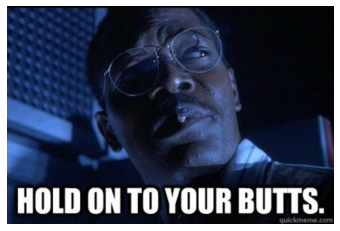

Finding Pulses...



Extracting Data...




########################## done ##########################


In [1]:
######################################################################
# Extract Pulse Widths and Integrated Charge from ASIC Waveform data #
#                        For all Cryocycles
#                       Author: Steven Doran                         #
######################################################################

# Import necessary packages
from scipy.signal import chirp, find_peaks, peak_widths   # peak-finding algoritm
import scipy as sp
from scipy import stats
import numpy  as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from tqdm.notebook import trange, tqdm      # progress bar
import os
import random

# Specify number of chips in set
TotalChips = int(100)
T = [i + 20 for i in range(TotalChips)]
# Specify Cryocycles
Cryocycles = [0,5,20,100]

# Automate Data Loading from .dat files (all .dat files of the form: chip100RT5IC.dat)
chips = []
for i in range(TotalChips):
    a = 'chip' + str(i+20)
    chips = np.append(chips,a)
data = []; txt = []
for i in range(len(chips)):
    data.append([]); txt.append([])
for i in range(len(chips)):
    for j in Cryocycles:
        e = 'DataRT' + str(j) + '_' + str(chips[i])
        data[i] = np.append(data[i],e)
        f = str(chips[i]) + 'RT' + str(j) + 'IC.dat'
        txt[i] = np.append(txt[i],f)

# Display meme for loading data
import matplotlib.image as mpimg
arr = os.listdir('memes')      # pull memes from this directory
RR = random.choice(arr)        # randomize the photo selection
plt.imshow(mpimg.imread('memes/' + RR))
plt.axis('off')
plt.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
Channel = []; Widths = []; ypoints_Ch = []; xpoints_Ch = []; LP = []; RP = []; Right = []; Left = []
peaks_x = []

# Build lists with correct dimensionality
for i in range(len(chips)):
    Channel.append([]); Widths.append([]); ypoints_Ch.append([]); peaks_x.append([])
    xpoints_Ch.append([]); LP.append([]); RP.append([]); Right.append([]); Left.append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        Channel[i].append([]); peaks_x[i].append([])
        Widths[i].append([]); ypoints_Ch[i].append([]); xpoints_Ch[i].append([])
        LP[i].append([]); RP[i].append([]); Right[i].append([]); Left[i].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            Channel[i][j].append(k); peaks_x[i][j].append([])
            Widths[i][j].append([]); ypoints_Ch[i][j].append([]); xpoints_Ch[i][j].append([])
            LP[i][j].append([]); RP[i][j].append([]); Right[i][j].append([]); Left[i][j].append([])
###########################################################################################
print('Finding Pulses...')
for i in trange(len(chips)):
    for j in range(len(Cryocycles)):
    # Load in chip data
        r = np.loadtxt(str(txt[i][j]),dtype=float,delimiter=None)
        rr = r.T[0]
        h = np.loadtxt(str(txt[i][j]),dtype=float,delimiter=None)
        hh = h.T[1]
        rr[:] = rr[:]-(25400*20)      # Normalize so that all subrun points run from 0:25399

        # sort chip data into 16 channels
        for k in range(0,16):
            xpoints_Ch[i][j][k] = rr[k*25400:(k+1)*25400]   # Array loading is funky - ensures its not of the form
            ypoints_Ch[i][j][k] = hh[k*25400:(k+1)*25400]   # [array[0,1,......,n]], but instead just [0,1,....,n]

            # Trace finding
            peaks, _ = find_peaks(ypoints_Ch[i][j][k], 3000)    # Impose Height Threshold (tells code to only look for peaks above that height)
            peaks = peaks[10:60]   # sample only the 'central' 50 peaks - avoid overlap from other subruns
            peaks_x[i][j][k].append(peaks)
            width = peak_widths(ypoints_Ch[i][j][k], peaks, rel_height=.5)  # Relative Height = points at which width is calculated
            list1 = width[0].tolist() # width of pulse                                      # 0.5 Relative Height = FWHM
            list2 = width[2].tolist() # interpolated left x-point of the width (@ Relative Height)
            list3 = width[3].tolist() # interpolated right x-point of the width
            j1 = [i for i in list1  if i >= 7 and i <= 17]  # impost width criteria (reject any pulses with widths outside of some distribution)
            j2 = [j for j in list2]; j3 = [j for j in list3]
            Widths[i][j][k] = j1; LP[i][j][k] = j2; RP[i][j][k] = j3

#####################################################################################################
# Need to impose width criteria on the L and R points of interpolation as well (to match other lists)
for i in range(len(RP)):
    for j in range(len(RP[i])):
        for k in range(len(RP[i][j])):
            for l in range(len(RP[i][j][k])):                # Match to Widths[] array
                if (RP[i][j][k][l]-LP[i][j][k][l]) >= 7 and (RP[i][j][k][l]-LP[i][j][k][l]) <= 17:
                    Right[i][j][k].append(RP[i][j][k][l]); Left[i][j][k].append(LP[i][j][k][l])
                    # These are int() because we need to match up the interpolated values (L and R) (decimals)
                    # to the actual x-points which are int. values from 0:25399

# Ensure correct dimensionality and organization of arrays
x_in_pulses = []; y_in_pulses = []
for i in range(len(chips)):
    x_in_pulses.append([]); y_in_pulses.append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        x_in_pulses[i].append([]); y_in_pulses[i].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            x_in_pulses[i][j].append([]); y_in_pulses[i][j].append([])
# append x and y points contained in the pulses to the specified arrays
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            for l in range(len(Widths[i][j][k])):   # Number of Pulses
                x_in_pulses[i][j][k].append([]); y_in_pulses[i][j][k].append([])
                # x_in_pulses --> captures data points in each pulse
                # x[chip][cryocycle][channel][specific pulse]
#####################################################################################################
print('Extracting Data...')
# Capturing the 'Pulse' - take data points between the two interpolated width points
for i in trange(len(chips)):
    for m in range(len(Cryocycles)):
        for j in range(0,16):
            for l in range(len(xpoints_Ch[i][m][j])):
                for k in range(len(Right[i][m][j])):
                    # Here's we're sampling a certain number of points to the left and right of the FWHM points
                    if xpoints_Ch[i][m][j][l] >= Left[i][m][j][k] - 10 and xpoints_Ch[i][m][j][l] <= Right[i][m][j][k] + 15:
                        x_in_pulses[i][m][j][k].append(xpoints_Ch[i][m][j][l])
                        y_in_pulses[i][m][j][k].append(ypoints_Ch[i][m][j][l])

# Code takes ~25 minutes to run for 1 Subrun, all 16 channels, all 100 ASICs per Cryocycle
print('\n########################## done ##########################')

In [2]:
# # # # # # # # # # # # # # # # # # # # # # #
'''
In the cells below, you rely on various arrays that were extracted from the .dat files.
This process takes ~50 minutes to load all data (above), so in the event of an accidental 
pedestalal subtraction to the actual array, you are fucked and forced to re-do the data loading.
To be safe, copy the various arrays loaded above to backup arrays, in
case you accidently re-run the cell and are otherwise forced to restart your
kernal (through trial and error we all find the way)
'''

import copy

# Perform a 'deep' copy, rather than a 'soft' copy
BU_x_in_pulses = copy.deepcopy(x_in_pulses); BU_y_in_pulses = copy.deepcopy(y_in_pulses);
BU_peaks_x = copy.deepcopy(peaks_x); BU_Widths = copy.deepcopy(Widths)

########################################################################
# Apply Backup
#x_in_pulses = copy.deepcopy(BU_x_in_pulses); y_in_pulses = copy.deepcopy(BU_y_in_pulses)
#peaks_x = copy.deepcopy(BU_peaks_x); Widths = copy.deepcopy(BU_Widths)
########################################################################

# Takes around 30 seconds for 100 ASICs, 3 cryocycles
print('done')

done



RT[0]

chip 20 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 21 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 22 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 23 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 24 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 25 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 26 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 27 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50]]
chip 28 :     [[50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50], [50],


79954.0  pulses sampled for RT[0]
80000 if all 50 pulses were sampled in each channel for 100 ASICs

79852.0  pulses sampled for RT[5]
80000 if all 50 pulses were sampled in each channel for 100 ASICs

79755.0  pulses sampled for RT[20]
80000 if all 50 pulses were sampled in each channel for 100 ASICs

76944.0  pulses sampled for RT[100]
80000 if all 50 pulses were sampled in each channel for 100 ASICs

Mean number of pulse points for RT[0] =  36.71

Mean number of pulse points for RT[5] =  36.66

Mean number of pulse points for RT[20] =  36.66

Mean number of pulse points for RT[100] =  36.54


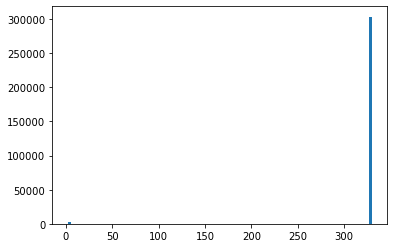

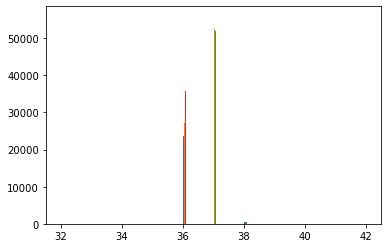



done


In [3]:
# See how many 'pulses' we catch in each subrun (Should be around 40)
Num_of_Pulses = []
for i in range(len(chips)):
    Num_of_Pulses.append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        Num_of_Pulses[i].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            Num_of_Pulses[i][j].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            Num_of_Pulses[i][j][k].append(len(Widths[i][j][k]))
for j in range(len(Cryocycles)):
    print('\nRT[' + str(Cryocycles[j]) + ']\n')
    for i in range(len(chips)):
        print('chip', i+20, ':    ', Num_of_Pulses[i][j])
    
# Average Distance between pulses
# Should be 329
Diff = []
for i in range(len(chips)):
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            for k in range(1,len(peaks_x[i][c][j][0])-1):
                d = peaks_x[i][c][j][0][k+1] - peaks_x[i][c][j][0][k]
                Diff.append(d)

plt.hist(Diff, bins = 100)

counter = 0.
for c in range(len(Cryocycles)):
    for i in range(len(chips)):
        for j in range(len(Num_of_Pulses[i][c])):
            counter = counter + Num_of_Pulses[i][c][j][0]
    print('\n'+ str(counter), ' pulses sampled for RT['+ str(Cryocycles[c]) + ']')
    print(str(50*16*len(chips)), 'if all 50 pulses were sampled in each channel for', len(chips), 'ASICs')
    counter = 0.

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Number of xpoints we capture in each pulse (Possibly tied to Calculated IC)
length_xpulse = []
for c in range(len(Cryocycles)):
    length_xpulse.append([])

fig1, ax1 = plt.subplots()
for c in range(len(Cryocycles)):
    for i in range(len(chips)):
        for j in range(0,16):
            for k in range(len(x_in_pulses[i][c][j])):
                length_xpulse[c].append(len(x_in_pulses[i][c][j][k]))
    print('\nMean number of pulse points for RT[' + 
          str(Cryocycles[c]) + '] = ', round(sum(length_xpulse[c])/len(length_xpulse[c]),2))

ax1.hist(length_xpulse, bins = 100)
plt.show()

print('\n\ndone')

In [4]:
'''Finding the Pedestal'''

# We observe in CT a significant sagging of the Pedestal Mean from channel to channel
# We first simply took the mu of the Pedestal Mean distribution and subtracted that single
# value from each y-point value before integrating the charge. Since the pedestal mean was
# different from channel to channel, that effect carried over to the IC. We will now sample
# all x-points that are not included in the pulses, take their respective y-point values
# and average over all the points not included in pulses to obtain true Pedestal values.
# We will then subtract the pedestal on a channel by channel basis

# Ensure correct dimensionality of the Pedestal array
Pedestal = []
for i in range(len(chips)):
    Pedestal.append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        Pedestal[i].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            Pedestal[i][j].append([])

# Load dummy array
ped_xpoints = xpoints_Ch

# Pedestal evaluation
print('Calculating Pedestal...')
for i in trange(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            for l in range(len(x_in_pulses[i][j][k])):  # Go through all ~50 pulses in a given channel
                
                # Find all x-points not contained in the pulses
                a = list(set(ped_xpoints[i][j][k])-set(x_in_pulses[i][j][k][l]))
                
                b = [] 
                # for all points in a (x points not in the pulses), find the respective y-points
                # (akin to finding the pedestal values)
                for e in a:
                    b.append(ypoints_Ch[i][j][k][int(e)])
                c = sum(b)/len(b)   # average over all y-point values                
                Pedestal[i][j][k].append(c)  # append Pedestal array
            
# There will be ~50 Pedestal averaged values for each channel (looped through ~50 pulses)
# Ordinarily we would average to get one value per channel, but we will apply the Pedestal
# subtraction to all y points in each of the pulses.


print('######################## done ########################')

Calculating Pedestal...



######################## done ########################


In [ ]:
# Remove disconnections (if pedestal is between 5750 and 625)       

# Need to apply this to the following arrays:
# Widths, y_in_pulses, x_in_pulses

for i in range(len(Pedestal)):
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if any(6250. > ele > 5750. for ele in Pedestal[i][c][j]):
                Widths[i][c][j] = []
                x_in_pulses[i][c][j] = []
                y_in_pulses[i][c][j] = []
                
print('done') 

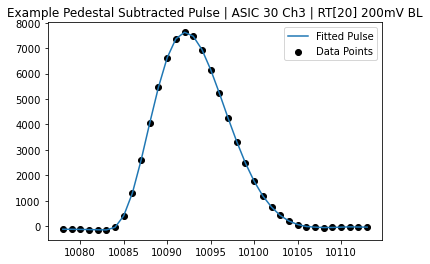

done


In [5]:
# Integration of all the pulses produced above -- yields Integrated Charge per Pulse
# with Pedestal subtraction

from scipy import integrate

# IC = avg values of pulses for a given ASIC, channel #
# Total = all pulse data for a given ASIC, channel #
# Spread = spread in data for all pulses in a given ASIC, channel #

IC = []; Total = []; spread = []
for i in range(len(chips)):
    Total.append([]); IC.append([]); spread.append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        Total[i].append([]); IC[i].append([]); spread[i].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            Total[i][j].append([]); IC[i][j].append([]); spread[i][j].append([])
            
# Apply Pedestal Subtraction
for i in range(len(chips)):
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            for k in range(len(y_in_pulses[i][c][j])):
                for l in range(len(y_in_pulses[i][c][j][k])):
                    y_in_pulses[i][c][j][k][l] = y_in_pulses[i][c][j][k][l] - Pedestal[i][c][j][k]

# Integrate under the pulse curve
for i in range(len(chips)):
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            for k in range(len(x_in_pulses[i][c][j])):
                integ = integrate.simps(y_in_pulses[i][c][j][k], x_in_pulses[i][c][j][k])
                Total[i][c][j].append(integ)

# append Integrated values to arrays 
for i in range(len(Total)):
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if len(Total[i][c][j]) != 0:
                g = sum(Total[i][c][j])/len(Total[i][c][j])
                IC[i][c][j].append(g)
                h = max(Total[i][c][j]) - min(Total[i][c][j])
                spread[i][c][j].append(h)

            if len(Total[i][c][j]) == 0:   # To avoid no pulses or discontinuties
                IC[i][c][j].append(0)
                spread[i][c][j].append(0)
            

'''Plot a sample Pulse from one Cryocycle'''
ChipN = 30     # Chip Number
CryoN = 2      # Cryocycle index -- RT[0] = 0   Rt[5] = 1  Rt[20] = 2
ChN = 3        # Channel Number
PN = 20        # Pulse Number

CC = [0,5,20,100]  # Cryocycle 
ChipN = ChipN - 20
plt.plot(x_in_pulses[ChipN][CryoN][ChN][PN], y_in_pulses[ChipN][CryoN][ChN][PN], label = 'Fitted Pulse')
plt.scatter(x_in_pulses[ChipN][CryoN][ChN][PN], y_in_pulses[ChipN][CryoN][ChN][PN],
            color = 'black', label = 'Data Points')
plt.title('Example Pedestal Subtracted Pulse | ASIC ' + str(ChipN+20) + ' Ch' + str(ChN) +
          ' | RT[' + str(CC[CryoN]) + '] 200mV BL')
plt.legend()
#plt.savefig('../../../../../RT_Pulse_Example_ASIC30_Ch3_RT20.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()
            
print('done')

In [14]:
# Finding the avg. Maximum Pulse Amplitude (Pedestal Subtracted) for RT/CT analysis. Exporting to .dat file too

MaxAmp = []
for c in range(len(Cryocycles)):
    MaxAmp.append([])    # bulk data array that will be a data dump for the .dat file
    
for c in range(len(Cryocycles)):
    for i in range(len(chips)):
        for j in range(0,16):
            counting = []
            for k in range(len(y_in_pulses[i][c][j])):
                z = max(y_in_pulses[i][c][j][k])
                counting.append(z)
            if len(counting) != 0:
                zz = sum(counting)/len(counting)
                MaxAmp[c].append(zz)


file10 = open('RT0_Avg_PA_50.dat', "w")
for i in range(len(MaxAmp[0])):             # RT[0]
    file10.write(str(MaxAmp[0][i]) + '\n')
file10.close()

file11 = open('RT5_Avg_PA_50.dat', "w")
for i in range(len(MaxAmp[1])):             # RT[5]
    file11.write(str(MaxAmp[1][i]) + '\n')
file11.close()

file12 = open('RT20_Avg_PA_50.dat', "w")
for i in range(len(MaxAmp[2])):             # RT[20]
    file12.write(str(MaxAmp[2][i]) + '\n')
file12.close()

print('done')

done


In [6]:
# Append arrays for loading them into a .dat file to export for histogram analysis

'''Integrated Charge'''
TotalIC_allchips = []
for c in range(len(Cryocycles)):
    TotalIC_allchips.append([])
for c in range(len(Cryocycles)):
    for i in range(len(chips)):
        for j in range(0,16):
            for k in range(len(Total[i][c][j])):
                TotalIC_allchips[c].append(Total[i][c][j][k])
            
'''Pulse Widths (FWHM)'''
TotalPW = []
for c in range(len(Cryocycles)):
    TotalPW.append([])
for c in range(len(Cryocycles)):
    for i in range(len(chips)):
        for j in range(0,16):
            for k in range(len(Widths[i][c][j])):
                TotalPW[c].append(Widths[i][c][j][k])
 

channel = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

print('done')

done


In [7]:
# Save histogram array data into .dat file to avoid loading data for ~45 minutes

# IC from all pulses into a single array - histogram displayed in two cells above
file0 = open('RT0_IC_data.dat', "w")
for i in range(len(TotalIC_allchips[0])):             # RT[0]
    file0.write(str(TotalIC_allchips[0][i]) + '\n')
file0.close()

file1 = open('RT5_IC_data.dat', "w")
for i in range(len(TotalIC_allchips[1])):             # RT[5]
    file1.write(str(TotalIC_allchips[1][i]) + '\n')
file1.close()

file2 = open('RT20_IC_data.dat', "w")
for i in range(len(TotalIC_allchips[2])):             # RT[20]
    file2.write(str(TotalIC_allchips[2][i]) + '\n')
file2.close()

file3 = open('RT100_IC_data.dat', "w")
for i in range(len(TotalIC_allchips[3])):             # RT[100]
    file3.write(str(TotalIC_allchips[3][i]) + '\n')
file3.close()


# PW from all pulses into a single array - displayed in above histogram
file4 = open('RT0_PW_data.dat', "w")
for i in range(len(TotalPW[0])):
    file4.write(str(TotalPW[0][i]) + '\n')
file4.close()

file5 = open('RT5_PW_data.dat', "w")
for i in range(len(TotalPW[1])):
    file5.write(str(TotalPW[1][i]) + '\n')
file5.close()

file6 = open('RT20_PW_data.dat', "w")
for i in range(len(TotalPW[2])):
    file6.write(str(TotalPW[2][i]) + '\n')
file6.close()

file7 = open('RT100_PW_data.dat', "w")
for i in range(len(TotalPW[3])):
    file7.write(str(TotalPW[3][i]) + '\n')
file7.close()


print('done')

done


### Individual Chip Plots

## Pulse Widths

In [8]:
# Creating 'Average' Widths for the primary point, which will be surronded by
# 'background' points from the other ~50 pulses

channel = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

Avg_W = []
for i in range(len(chips)):
    Avg_W.append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        Avg_W[i].append([])
for i in range(len(chips)):
    for j in range(len(Cryocycles)):
        for k in range(0,16):
            Avg_W[i][j].append([])
    
for i in range(len(chips)):
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if len(Widths[i][c][j]) != 0:
                average = sum(Widths[i][c][j])/len(Widths[i][c][j])
                Avg_W[i][c][j].append(average)
            else:  # To avoid division by zero
                averageNaN = 0.
                Avg_W[i][c][j].append(averageNaN)

print('done')

done


In [9]:
'''Pulse Widths'''

import matplotlib.lines as mlines

def PW(Title,AveragePW,chipIndex,path,path_cache):
    
    fig, (a) = plt.subplots(1)
    a.title.set_text(Title)
    plt.ylabel('Pulse FWHM', loc = 'center')
    plt.xlabel('P3 LArASIC Channel Number', loc = 'right')
    a.set_xticks(range(0,16))
    
    # Specify Colors for Cryocycles
    color0 = 'green'
    color5 = 'blue'
    color20 = 'red'
    color100 = 'black'
    
    RTcolors = [color0, color5, color20, color100]
    RTmark = ['x', 'x', 'x', 'x']
    pos = [0,1,2,3]   # position the PW = 0 points will be displayed
    
    # PW y-limit
    a.set_ylim([-1,25])
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #    
    # Custom Legend
    RT0_point = mlines.Line2D([],[],color=color0, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[0] ASIC PW Data')
    RT5_point = mlines.Line2D([],[],color=color5, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[5] ASIC PW Data')
    RT20_point = mlines.Line2D([],[],color=color20, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[20] ASIC PW Data')
    RT100_point = mlines.Line2D([],[],color=color100, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[100] ASIC PW Data')
    nopulses_RT0 = mlines.Line2D([],[],color=color0, marker = RTmark[0], linestyle = 'None',
                              markersize = 6, label = 'RT[0] PW = 0 (no Pulses)')
    nopulses_RT5 = mlines.Line2D([],[],color=color5, marker = RTmark[1], linestyle = 'None',
                              markersize = 6, label = 'RT[5] PW = 0 (no Pulses)')
    nopulses_RT20 = mlines.Line2D([],[],color=color20, marker = RTmark[2], linestyle = 'None',
                              markersize = 6, label = 'RT[20] PW = 0 (no Pulses)')
    nopulses_RT100 = mlines.Line2D([],[],color=color100, marker = RTmark[3], linestyle = 'None',
                              markersize = 6, label = 'RT[100] PW = 0 (no Pulses)')
    a.legend(handles=[RT0_point,RT5_point, RT20_point, RT100_point,nopulses_RT0,nopulses_RT5,nopulses_RT20,
                     nopulses_RT100],bbox_to_anchor=(1.45,.95), title = 'Marker Legend', 
             loc='upper right', fontsize = 5, ncol = 1, shadow = True)
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Plotting the channel data (Avg PW) for all cryocycles
    # RT[0]
    a.plot(channel,AveragePW[0],marker='.',color=color0,zorder=6)
    # RT[5]
    a.plot(channel,AveragePW[1],marker='.',color=color5,zorder=7)
    # RT[20]
    a.plot(channel,AveragePW[2],marker='.',color=color20,zorder=8)
    # RT[100]
    a.plot(channel,AveragePW[3],marker='.',color=color100,zorder=9)
    
    # Blue marker for pulse widths of 0
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if AveragePW[c][j][0] == 0.:
                #a.scatter(channel[j], AveragePW[c][j], color = RTcolors[c], marker = RTmark[c], s=45, zorder = 5)
                a.scatter(channel[j], pos[c], color = RTcolors[c], marker = 'x', s=35, zorder = 5)
    
    # Plotting spread of other pulses (~50) within that channel of the ASIC for comparison
    for c in range(len(Cryocycles)):
        y_up = np.array([]); y_down = np.array([])
        for j in range(0,16):
            if len(Total[chipIndex][c][j]) != 0.:
                ymin = min(Widths[chipIndex][c][j]); ymax = max(Widths[chipIndex][c][j])
                ytop = ymax - Avg_W[chipIndex][c][j][0]; ybot = Avg_W[chipIndex][c][j][0] - ymin
                y_up = np.append(y_up,ytop); y_down = np.append(y_down,ybot)
            else:
                ytop = 0.; ybot = 0.
                y_up = np.append(y_up,ytop); y_down = np.append(y_down,ybot)
        
        yspread = [y_up, y_down]
        a.errorbar(channel,Avg_W[chipIndex][c], yerr=yspread, color = RTcolors[c], ls = 'none')
        
    a.tick_params(axis='y', labelsize=8)
    
    # # # # # # # # # # # # # # # # 
    plt.subplots_adjust(right=.8)
    
    # If you want to save to folder -- must adjust the function (add path to variable)
    plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
    plt.savefig(path_cache,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

    plt.show()

    return

print('done')

done


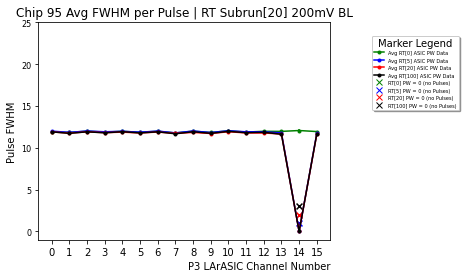


done


In [12]:
'''Run to produce a plot for a single ASIC'''

chipNumber = 95

Title = 'Chip ' + str(chipNumber) + ' Avg FWHM per Pulse | RT Subrun[20] 200mV BL'
chipIndex = int(chipNumber - 20)
AveragePW = Avg_W[chipIndex]
path = '../../../../../test.png'
path_cache = '../../../../../test.png'
PW(Title,AveragePW,chipIndex,path,path_cache)
print('\ndone')

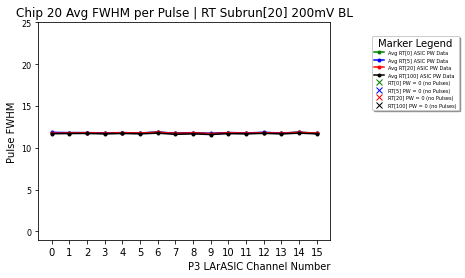

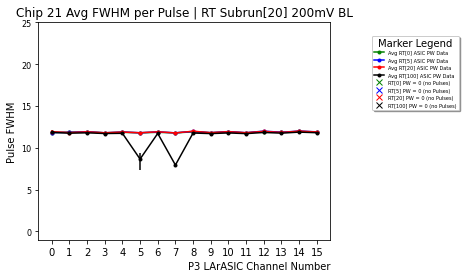

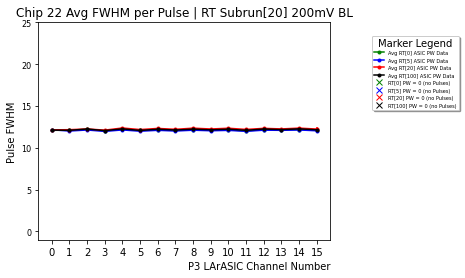

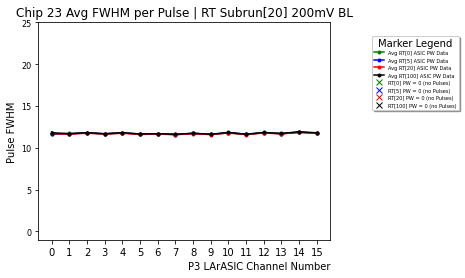

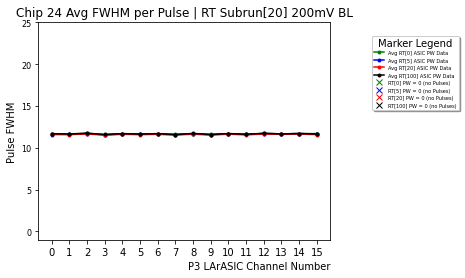

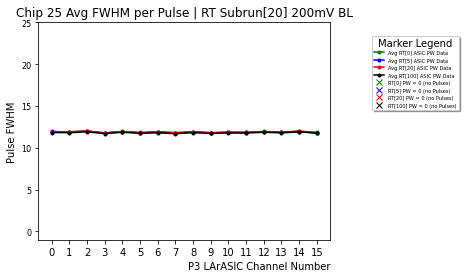

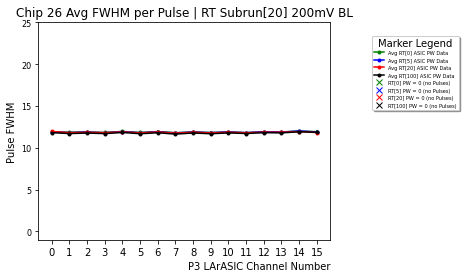

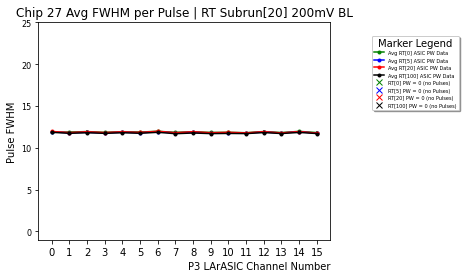

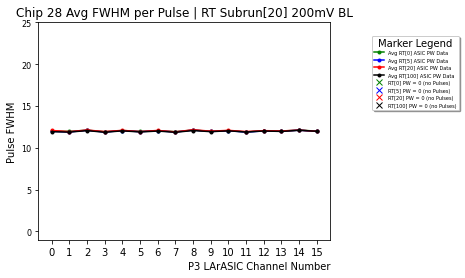

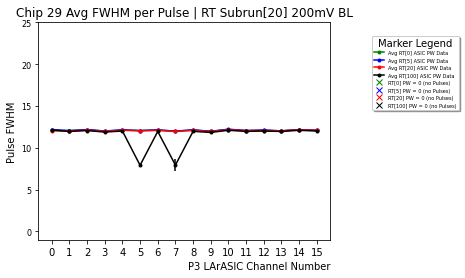

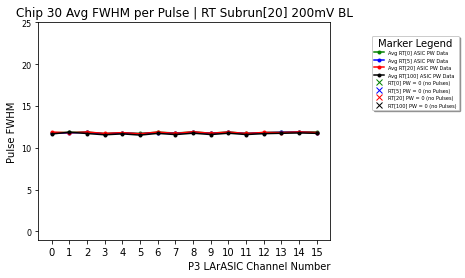

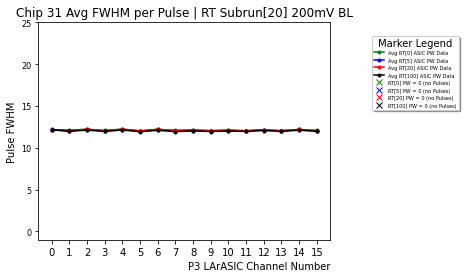

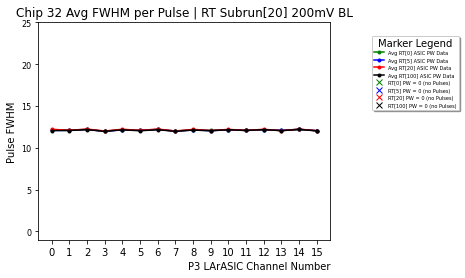

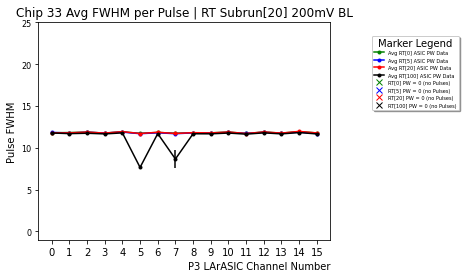

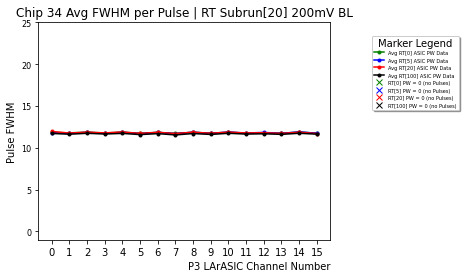

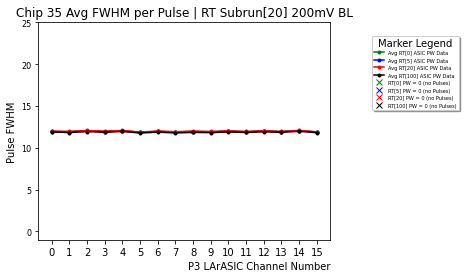

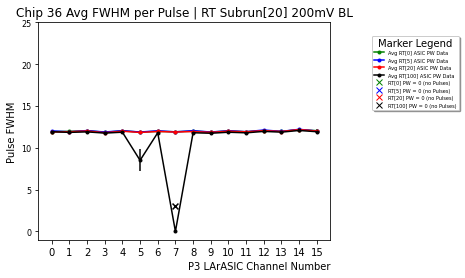

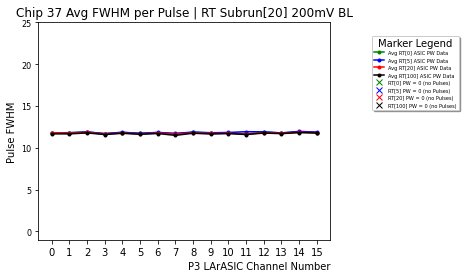

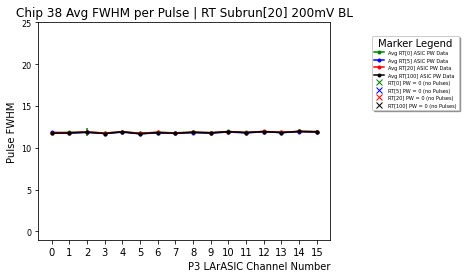

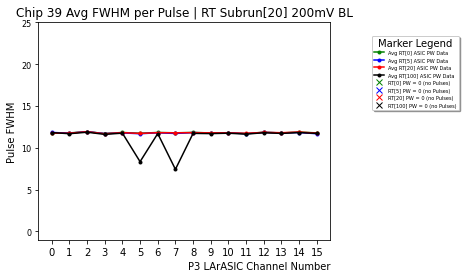

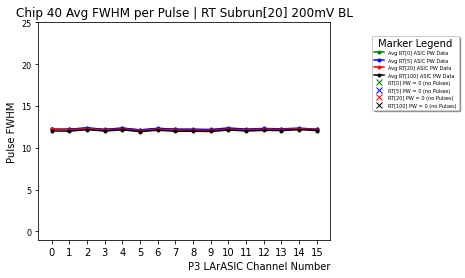

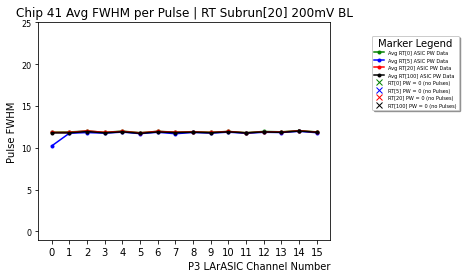

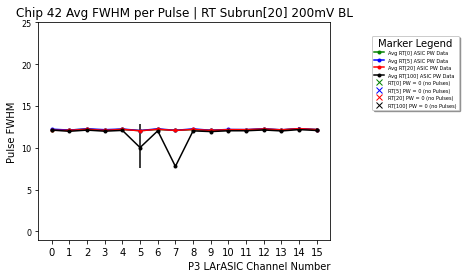

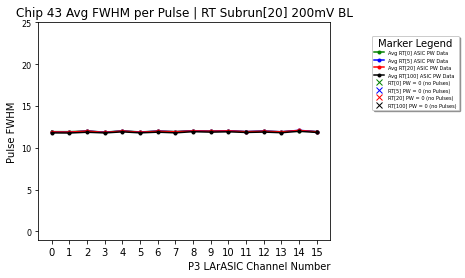

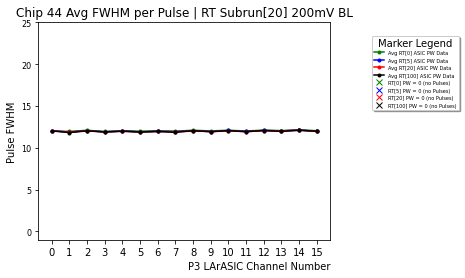

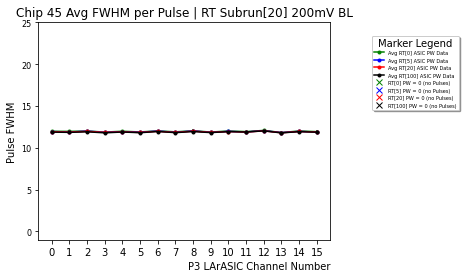

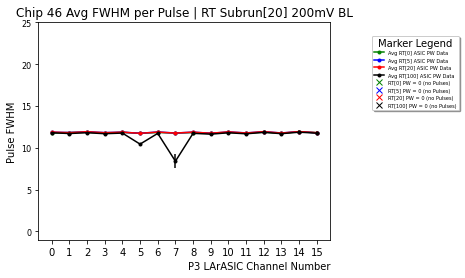

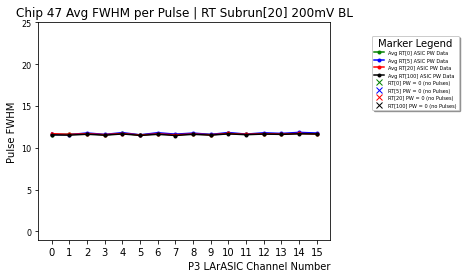

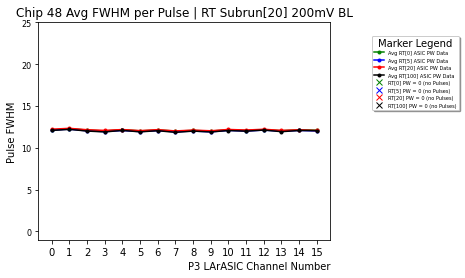

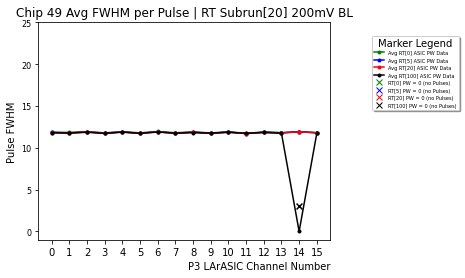

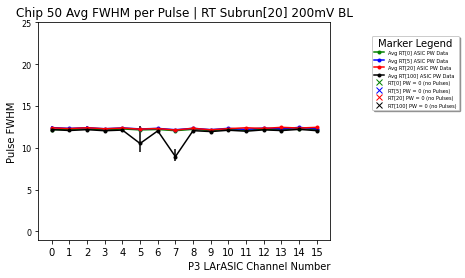

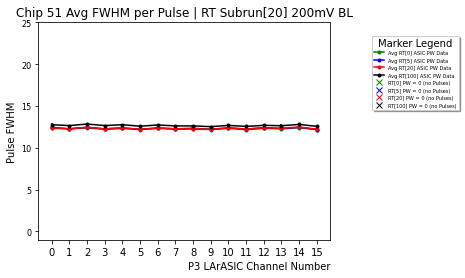

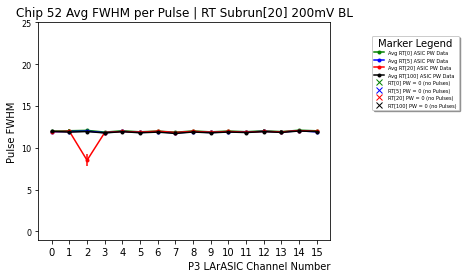

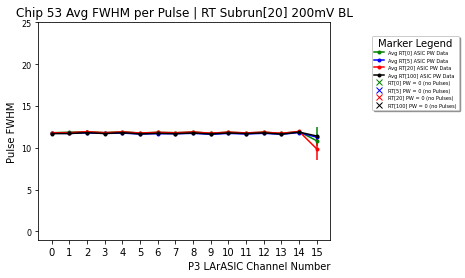

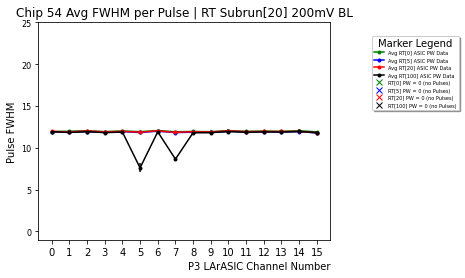

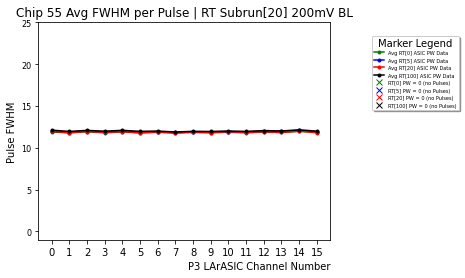

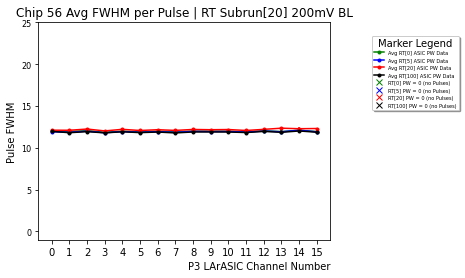

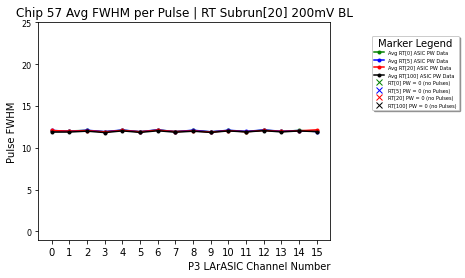

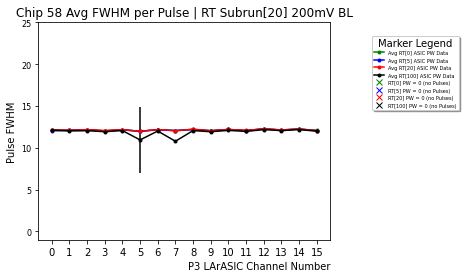

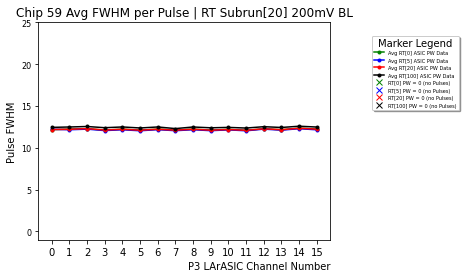

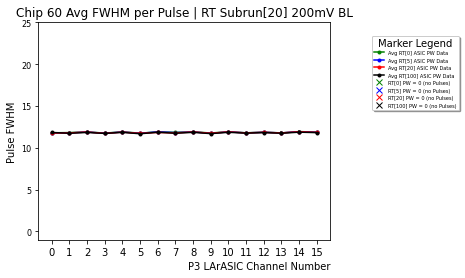

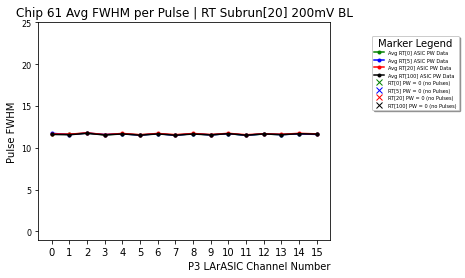

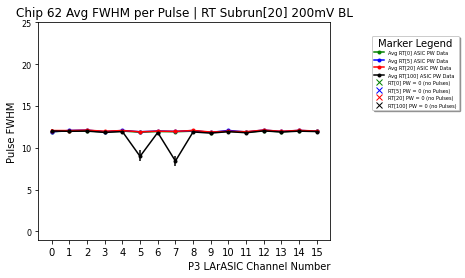

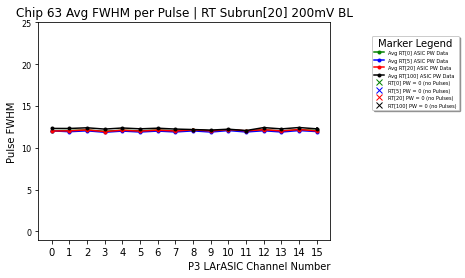

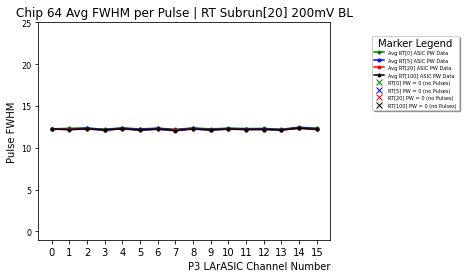

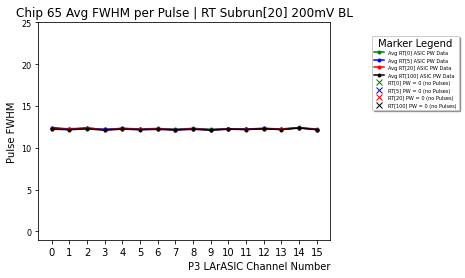

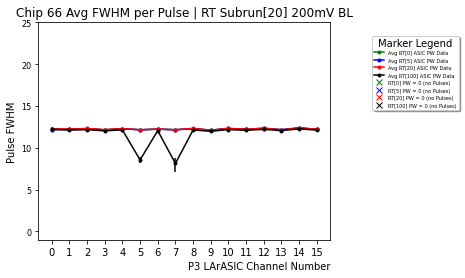

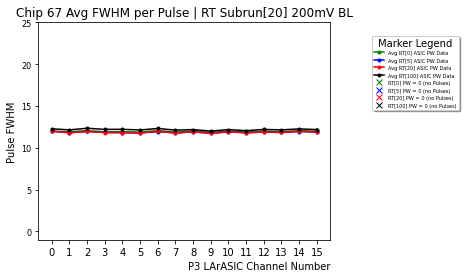

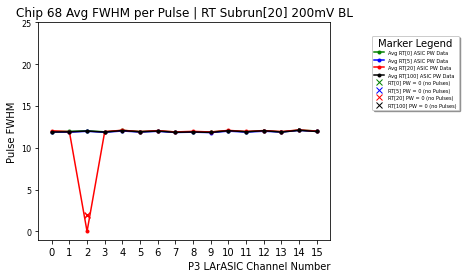

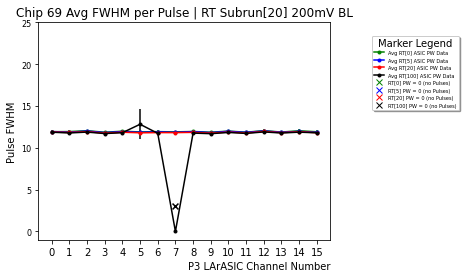

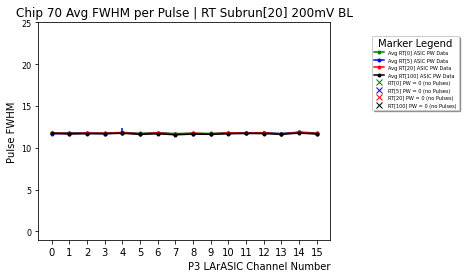

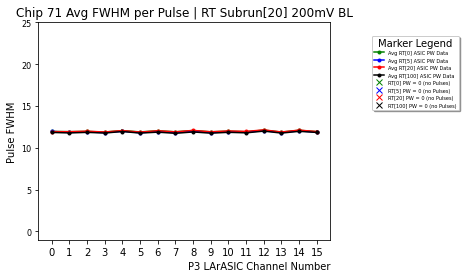

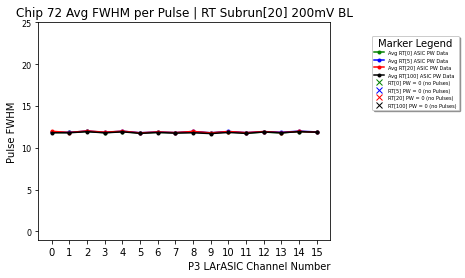

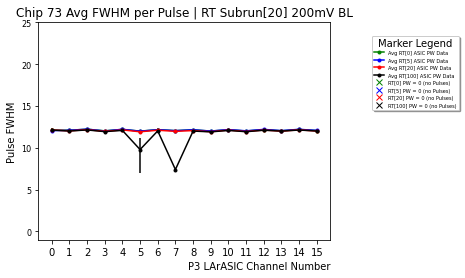

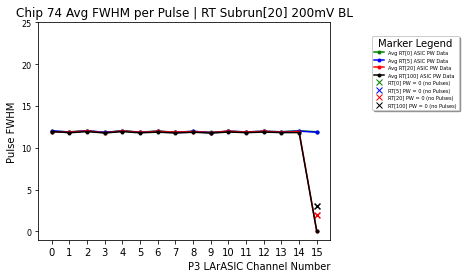

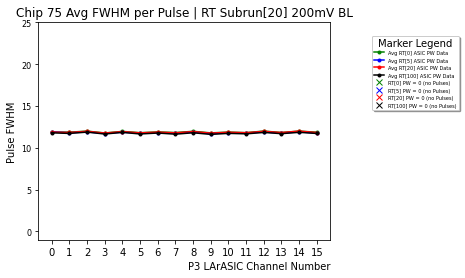

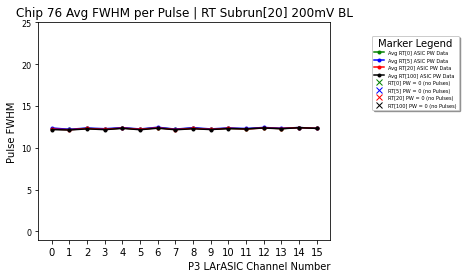

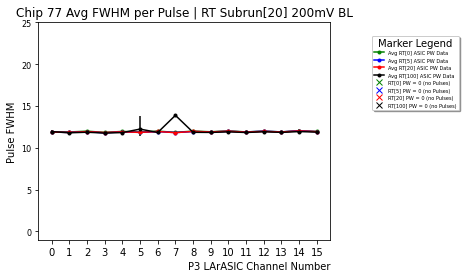

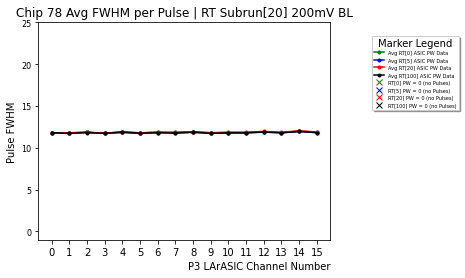

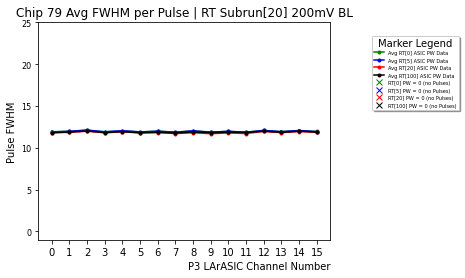

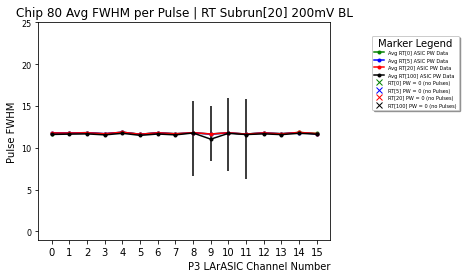

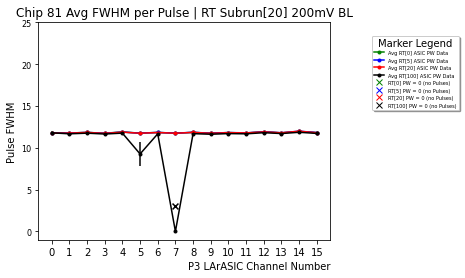

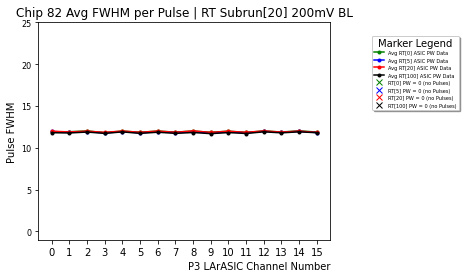

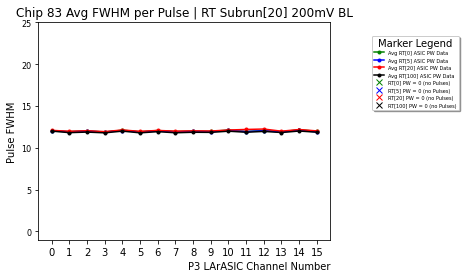

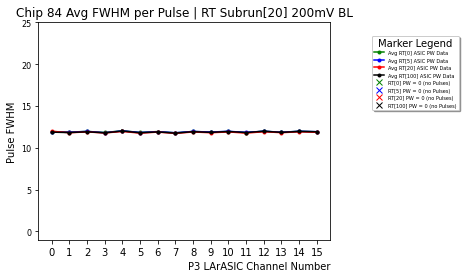

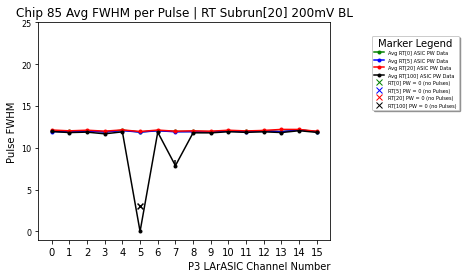

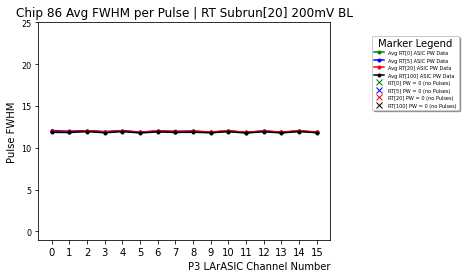

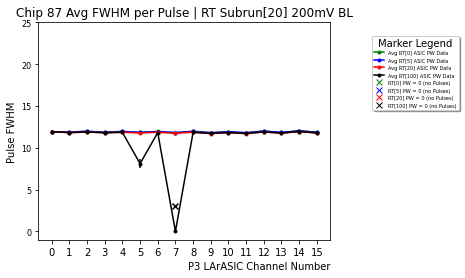

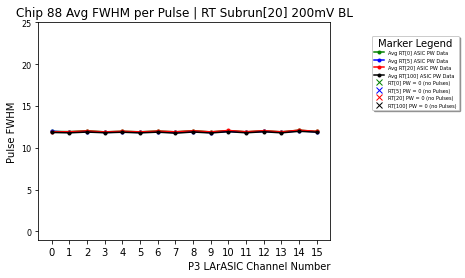

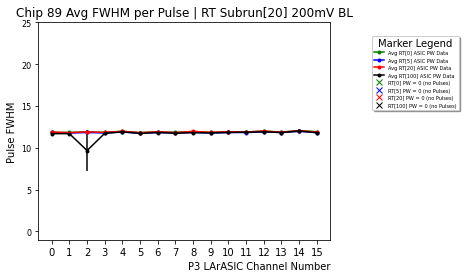

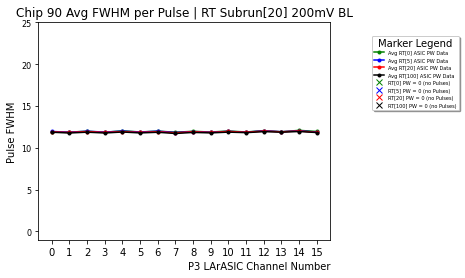

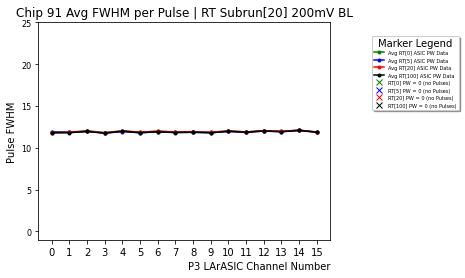

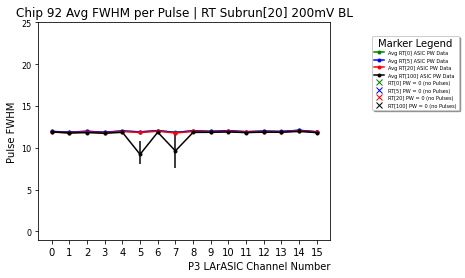

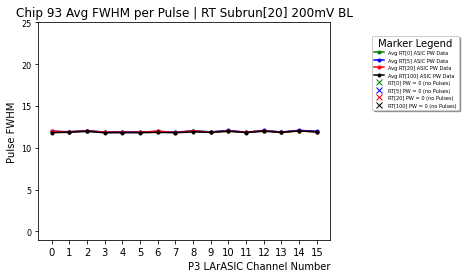

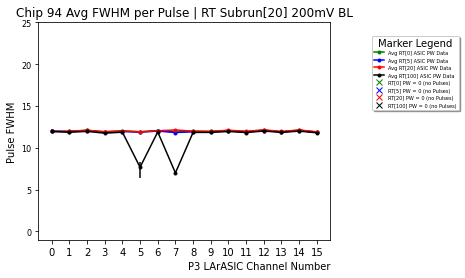

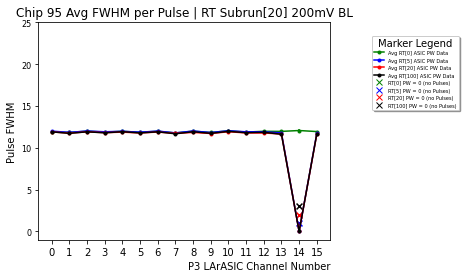

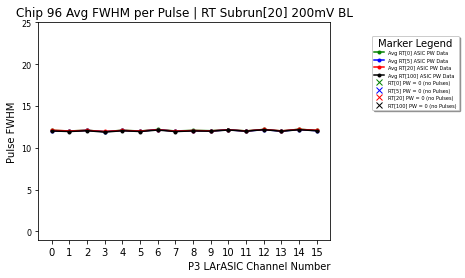

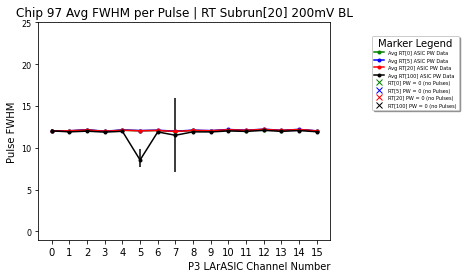

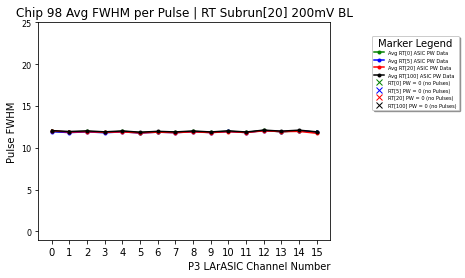

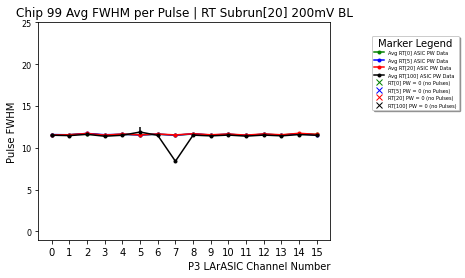

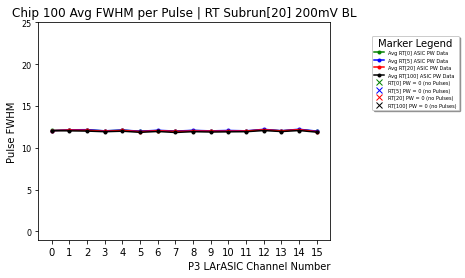

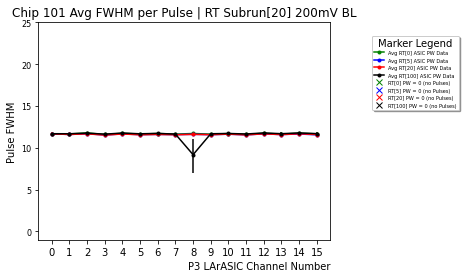

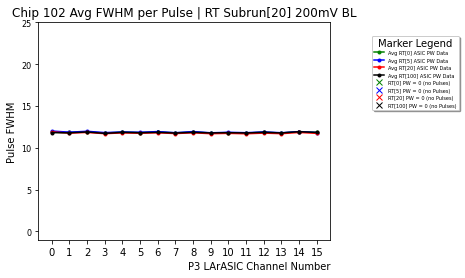

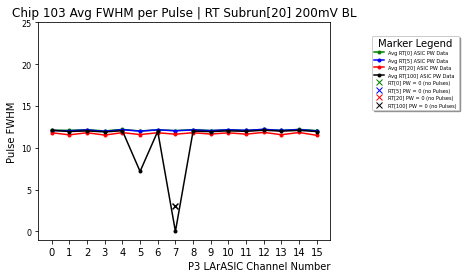

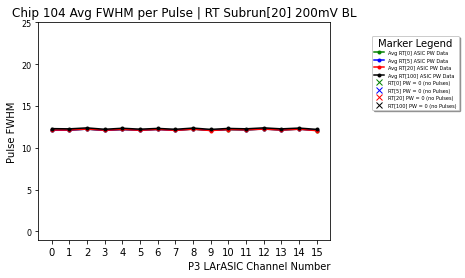

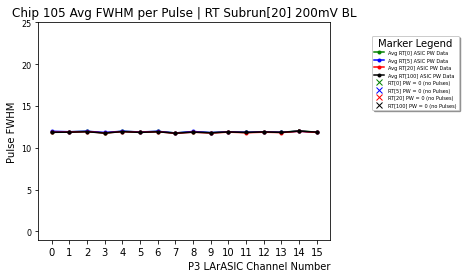

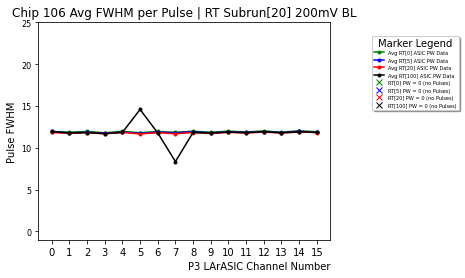

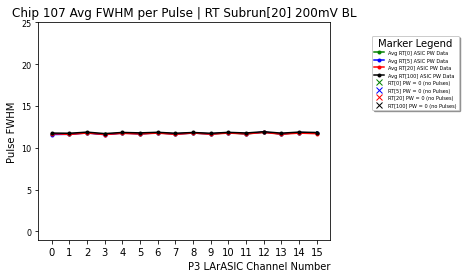

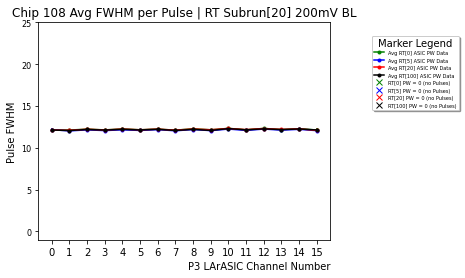

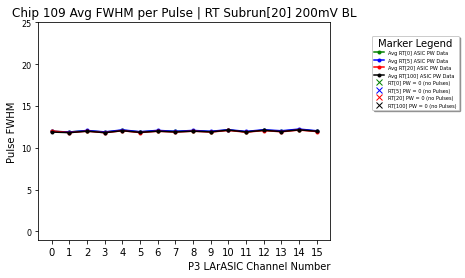

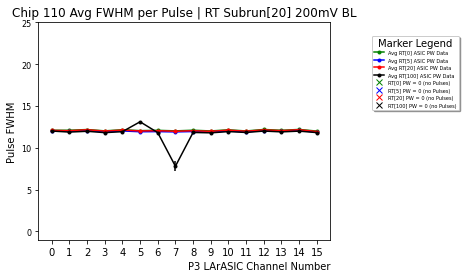

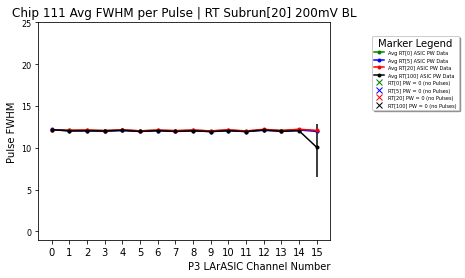

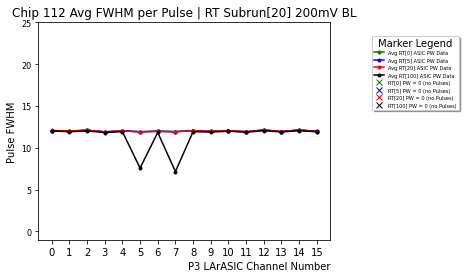

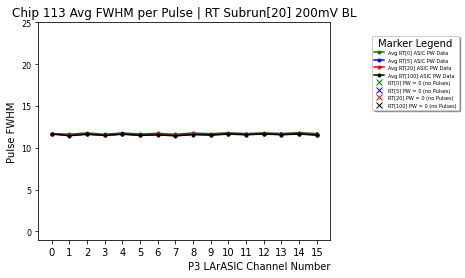

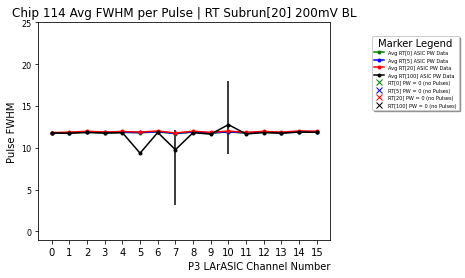

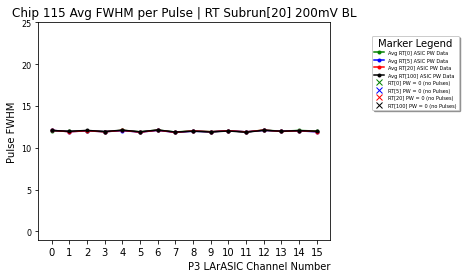

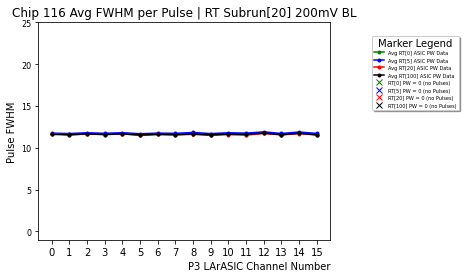

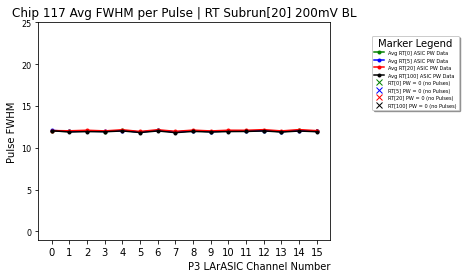

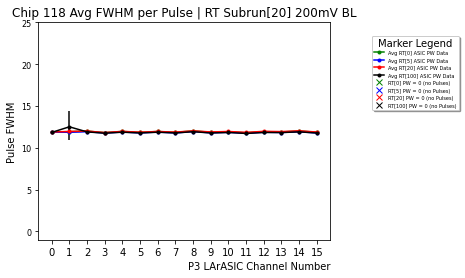

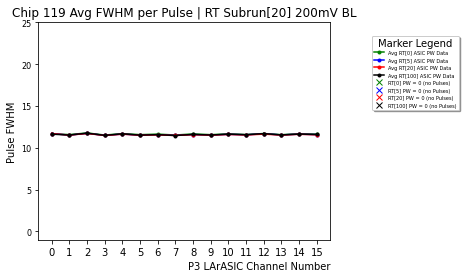


done


In [13]:
'''Produce all chips'''

for i in range(len(chips)):
    chipIndex = int(i)
    Title = 'Chip ' + str(chipIndex+20) + ' Avg FWHM per Pulse | RT Subrun[20] 200mV BL'
    AveragePW = Avg_W[chipIndex]
    path = '../../Cryocycled Chip Catalog/' + str(i+20) + '/' + str(i+20) + ' RT FWHM.png'
    path_cache = '../../Cryocycled Chip Catalog Photo Cache/' + str(i+20) + ' RT FWHM.png'
    PW(Title,AveragePW,chipIndex,path,path_cache)
    
print('\ndone')

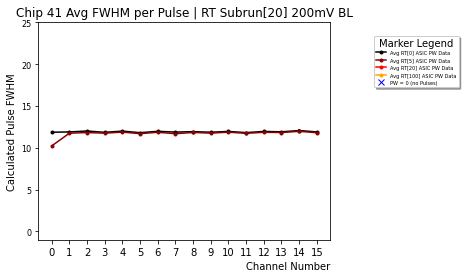

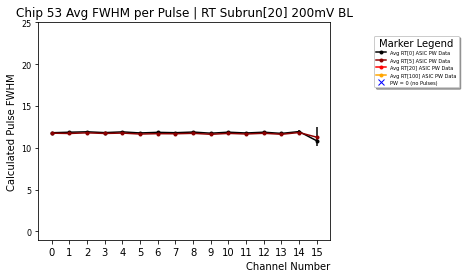

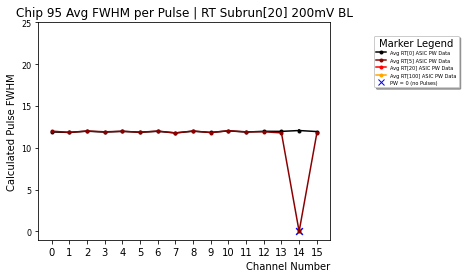


done


In [32]:
'''Produce only Problematic (outside of 5-sigma) Chips'''

mu_0 = 11.9; sig_0 = 0.2   # RT[0] Distributions for Pulse FWHM
mu_5 = 11.9; sig_5 = 0.2   # RT[5] Distribution

plus5_RT0 = (mu_0 + 5*sig_0); minus5_RT0 = (mu_0 - 5*sig_0)
plus5_RT5 = (mu_5 + 5*sig_5); minus5_RT5 = (mu_5 - 5*sig_5)

sigma = [[plus5_RT0, minus5_RT0],[plus5_RT5, minus5_RT5]]

IN = [i for i in range(len(chips))]

# State that if any of the channels for an ASIC have pulse widths outside of 5-sigma for any of their 
# cryocycles to append an array (RTcounter) - if that array is non-zero for any element (an ASIC)
# plot and save that ASIC to a directory

RTcounter = [0 for i in range(len(chips))]
for i in IN:
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if any(e > sigma[c][0] for e in Widths[i][c][j]) or any(e < sigma[c][1] for e in Widths[i][c][j]) \
            or len(Widths[i][c][j]) == 0.:
                RTcounter[i] = RTcounter[i] + 1.

# plot any ASICs with non-zero values (corresponding to any pulses in any channels having FWHM values
# outside of 5-sigma from the mean) in the RTcounter array to a 'Problematic Chips' directory

for i in IN:
    if RTcounter[i] != 0.:
        chipIndex = int(i)
        Title = 'Chip ' + str(chipIndex+20) + ' Avg FWHM per Pulse | RT Subrun[20] 200mV BL'
        AveragePW = Avg_W[chipIndex]
        path = '../../Plots/Cryocycle Comparison/IC and PW/Problematic Chips RT/RT CC FWHM '+str(i+20)+'.png'
        path_cache = '../../../../../test.png'
        PW(Title,AveragePW,chipIndex,path,path_cache)


print('\ndone')

## Integrated Charge

In [14]:
'''Integrated Charge'''

import matplotlib.lines as mlines

def IntCharge(Title,IntegratedCharge,chipIndex,path,path_cache):
    
    fig, (a) = plt.subplots(1)
    a.title.set_text(Title)
    plt.ylabel('Integrated Charge', loc = 'center')
    plt.xlabel('P3 LArASIC Channel Number', loc = 'right')
    a.set_xticks(range(0,16))
    
    # Specify Colors for Cryocycles
    color0 = 'green'
    color5 = 'blue'
    color20 = 'red'
    color100 = 'black'
    
    RTcolors = [color0, color5, color20, color100]
    RTmark = ['x', 'x', 'x', 'x']
    pos = [52700,55400,58100,60800]
    
    # IC y-limit
    a.set_ylim([50000,120000])
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Custom Legend
    RT0_point = mlines.Line2D([],[],color=color0, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[0] ASIC IC Data')
    RT5_point = mlines.Line2D([],[],color=color5, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[5] ASIC IC Data')
    RT20_point = mlines.Line2D([],[],color=color20, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[20] ASIC IC Data')
    RT100_point = mlines.Line2D([],[],color=color100, marker = '.', linestyle = '-',
                              markersize = 6, label = 'Avg RT[100] ASIC IC Data')
    nopulses_RT0 = mlines.Line2D([],[],color=color0, marker = RTmark[0], linestyle = 'None',
                              markersize = 6, label = 'RT[0] IC = 0 (no Pulses)')
    nopulses_RT5 = mlines.Line2D([],[],color=color5, marker = RTmark[1], linestyle = 'None',
                              markersize = 6, label = 'RT[5] IC = 0 (no Pulses)')
    nopulses_RT20 = mlines.Line2D([],[],color=color20, marker = RTmark[2], linestyle = 'None',
                              markersize = 6, label = 'RT[20] IC = 0 (no Pulses)')
    nopulses_RT100 = mlines.Line2D([],[],color=color100, marker = RTmark[3], linestyle = 'None',
                              markersize = 6, label = 'RT[100] IC = 0 (no Pulses)')
    a.legend(handles=[RT0_point,RT5_point, RT20_point, RT100_point,nopulses_RT0,nopulses_RT5,nopulses_RT20,
                     nopulses_RT100],bbox_to_anchor=(1.45,.95), title = 'Marker Legend', 
             loc='upper right', fontsize = 5, ncol = 1, shadow = True)
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    
    # Plotting the channel data (Avg PW) for all cryocycles
    # RT[0]
    a.plot(channel,IntegratedCharge[0],marker='.',color=color0,zorder=6)
    # RT[5]
    a.plot(channel,IntegratedCharge[1],marker='.',color=color5,zorder=7)
    # RT[20]
    a.plot(channel,IntegratedCharge[2],marker='.',color=color20,zorder=8)
    # RT[100]
    a.plot(channel,IntegratedCharge[3],marker='.',color=color100,zorder=9)
    
    
    # Blue marker for IC of 0 (place at lowest point of y-axis window range ~50000)
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if IntegratedCharge[c][j][0] == 0.:
                #a.scatter(channel[j], 55000., color = 'blue', marker = 'x', s=45, zorder = 5)
                a.scatter(channel[j], pos[c], color = RTcolors[c], marker = 'x', s=35, zorder = 5)
    
    # Plotting spread of other pulses (~50) within that channel of the ASIC for comparison
    for c in range(len(Cryocycles)):
        y_up = np.array([]); y_down = np.array([])
        for j in range(0,16):
            if len(Total[chipIndex][c][j]) != 0.:
                ymin = min(Total[chipIndex][c][j]); ymax = max(Total[chipIndex][c][j])
                ytop = ymax - IC[chipIndex][c][j][0]; ybot = IC[chipIndex][c][j][0] - ymin
                y_up = np.append(y_up,ytop); y_down = np.append(y_down,ybot)
            else:
                ytop = 0.; ybot = 0.
                y_up = np.append(y_up,ytop); y_down = np.append(y_down,ybot)

        yspread = [y_up, y_down]  
        a.errorbar(channel,IC[chipIndex][c], yerr=yspread, color = RTcolors[c], ls = 'none')
        
    a.tick_params(axis='y', labelsize=8)
    
    # # # # # # # # # # # # # # # # 
    plt.subplots_adjust(right=.8)
    
    # If you want to save to folder -- must adjust the function (add path to variable)
    plt.savefig(path,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
    plt.savefig(path_cache,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')

    plt.show()

    return

print('done')

done


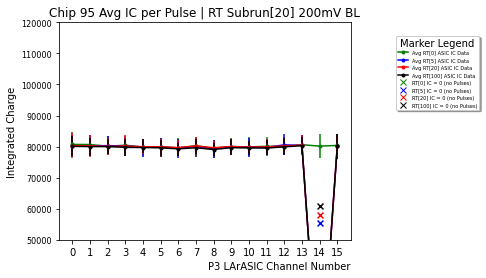


done


In [16]:
'''Run to produce a plot for a single ASIC'''

chipNumber = 95

Title = 'Chip ' + str(chipNumber) + ' Avg IC per Pulse | RT Subrun[20] 200mV BL'
chipIndex = int(chipNumber - 20)
IntegratedCharge = IC[chipIndex]
path = '../../../../../test.png'
path_cache = '../../../../../test.png'
IntCharge(Title,IntegratedCharge,chipIndex,path,path_cache)
print('\ndone')

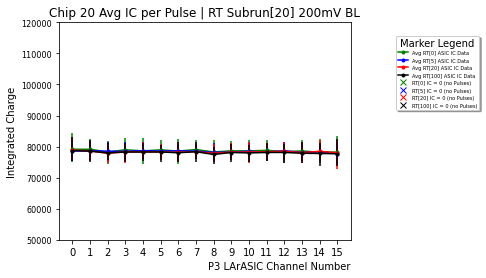

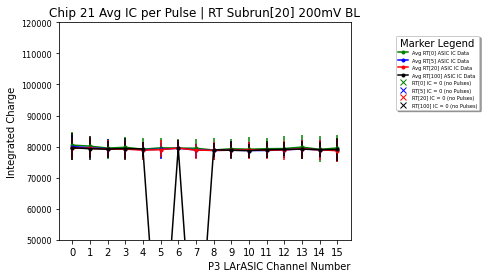

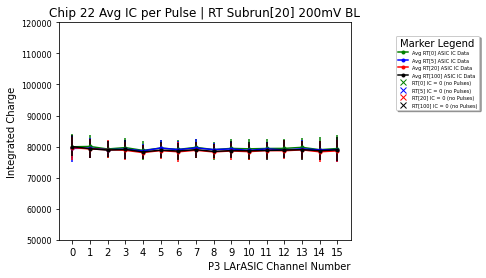

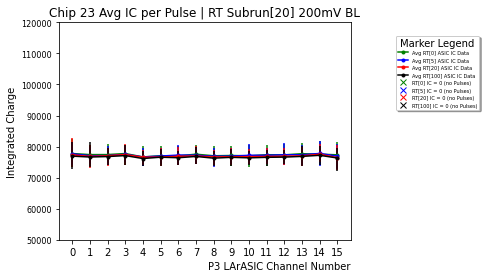

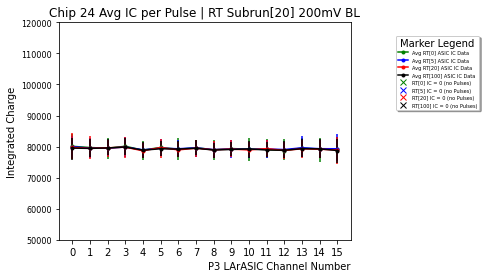

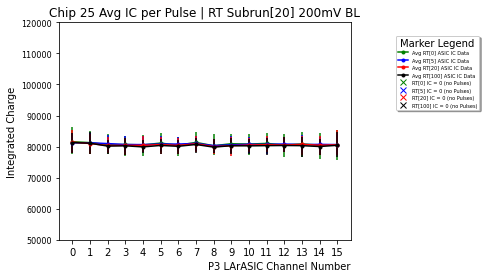

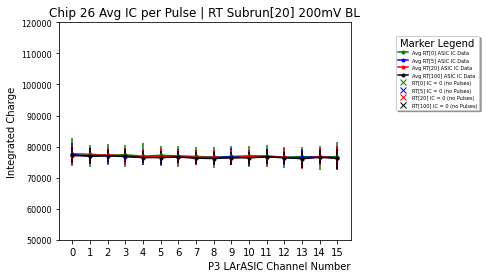

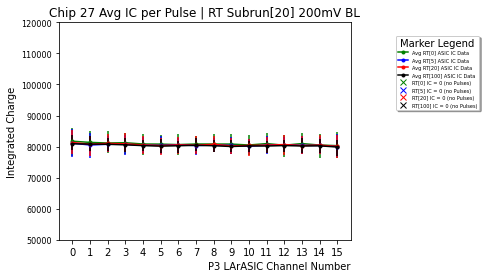

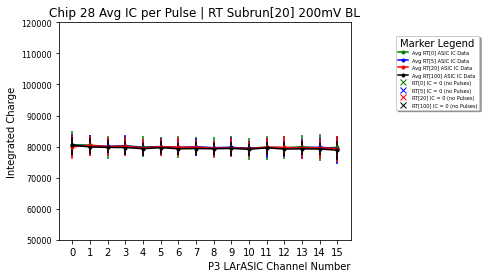

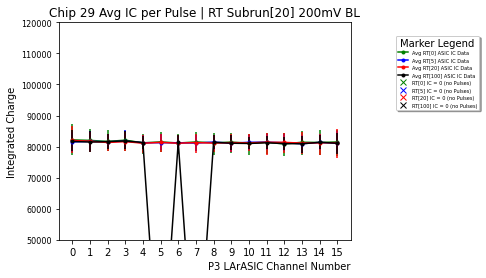

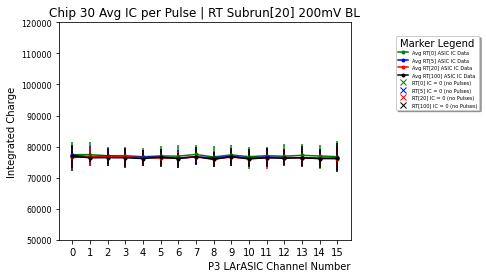

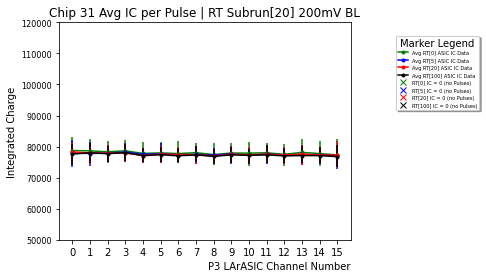

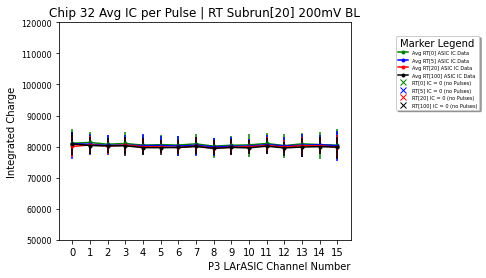

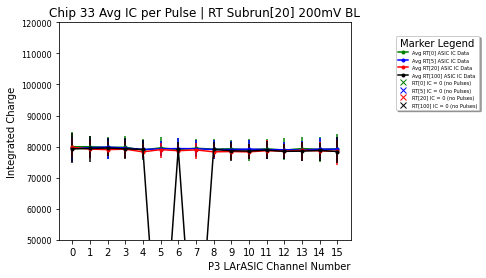

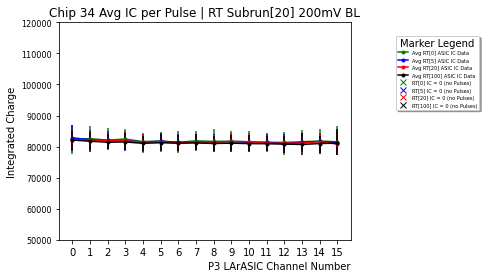

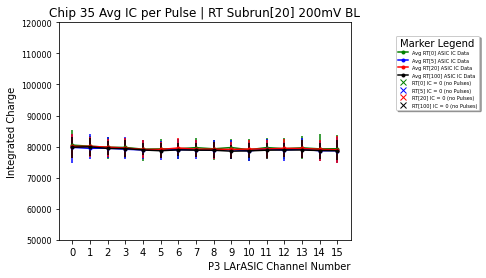

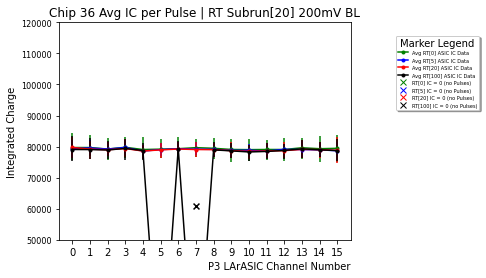

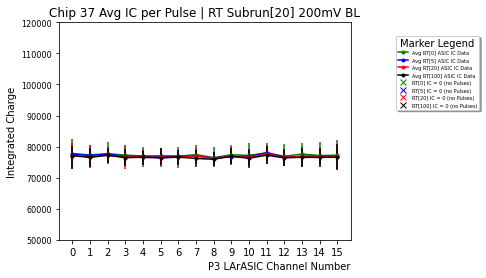

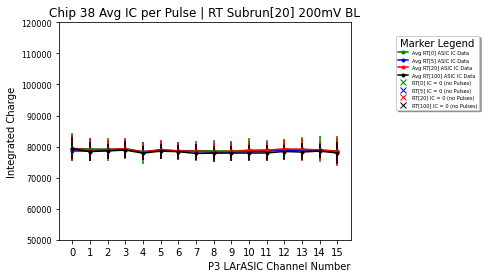

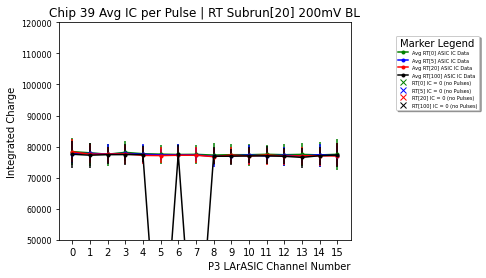

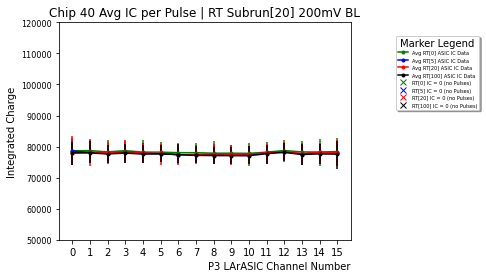

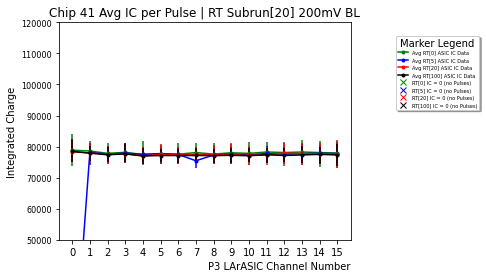

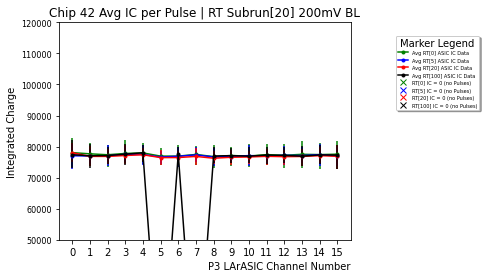

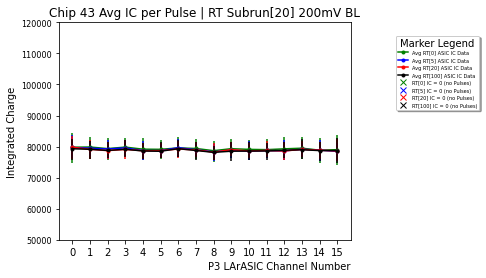

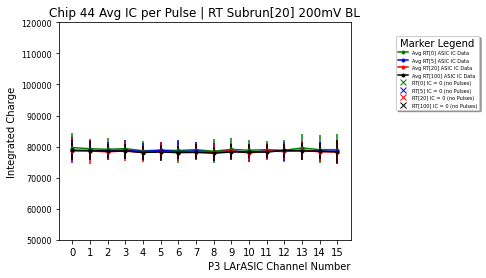

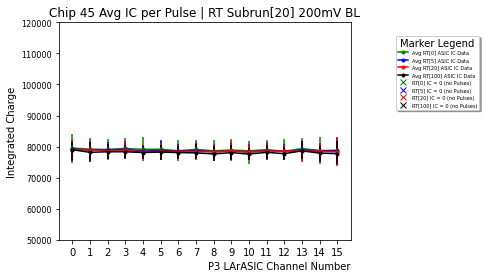

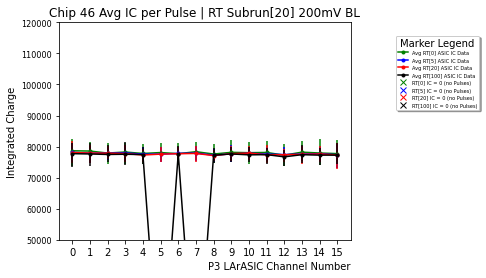

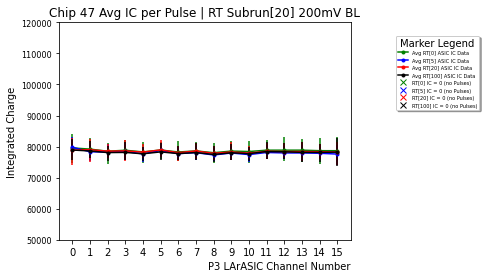

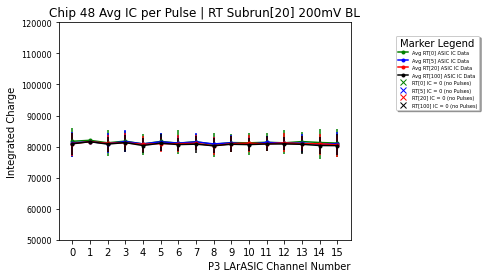

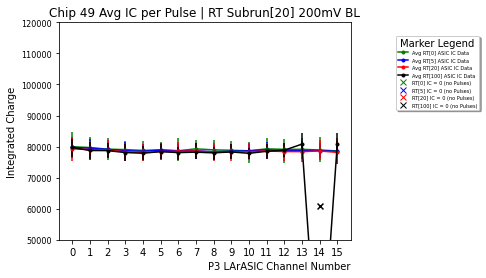

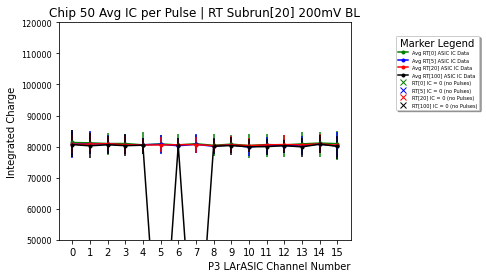

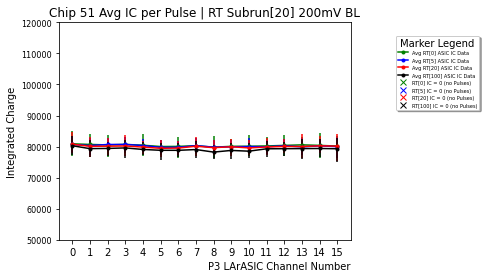

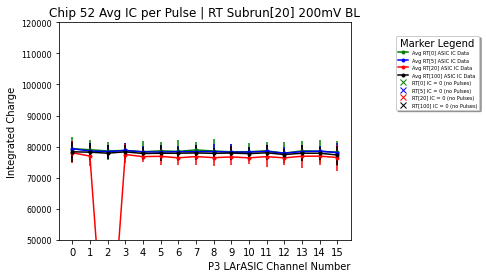

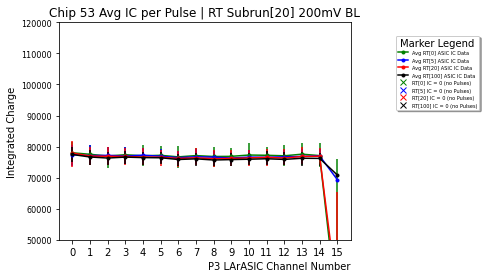

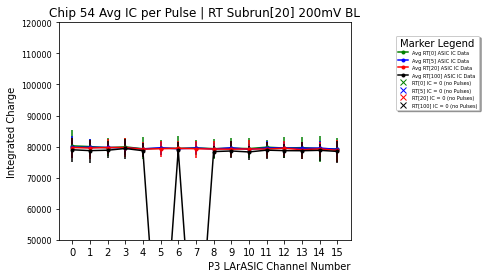

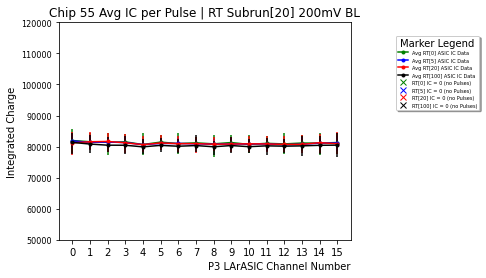

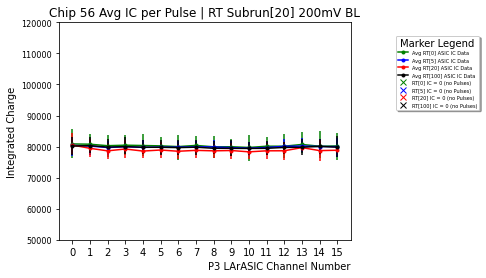

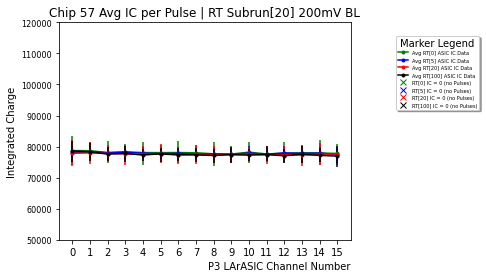

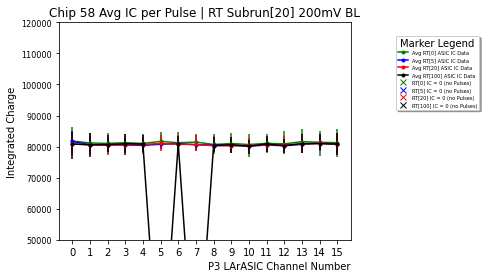

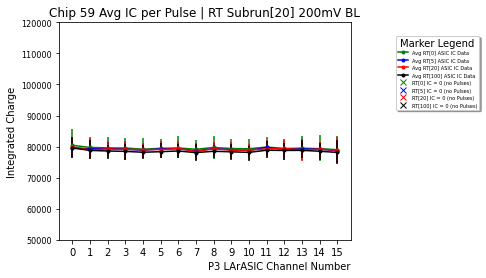

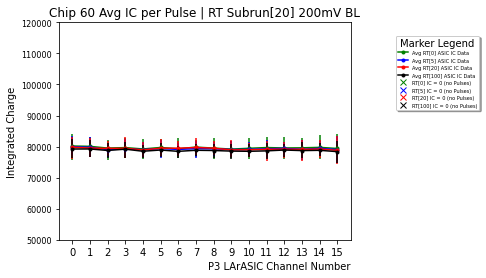

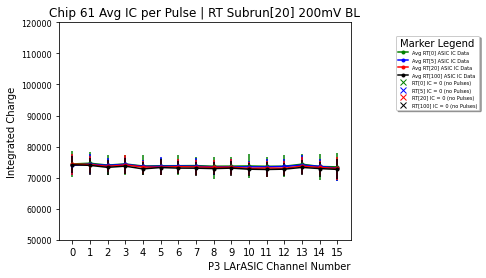

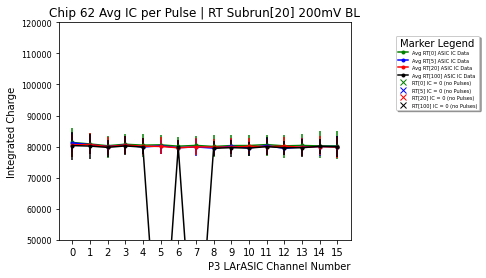

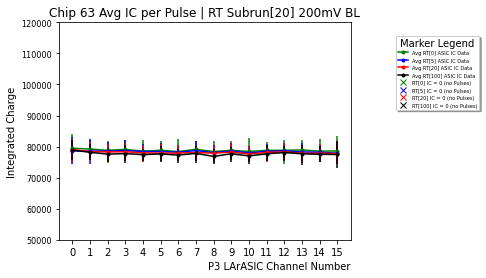

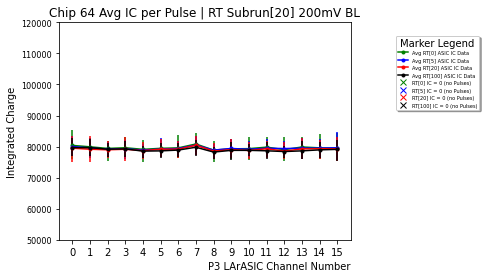

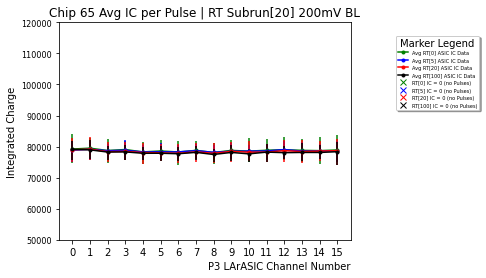

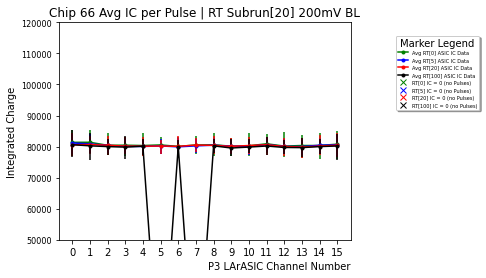

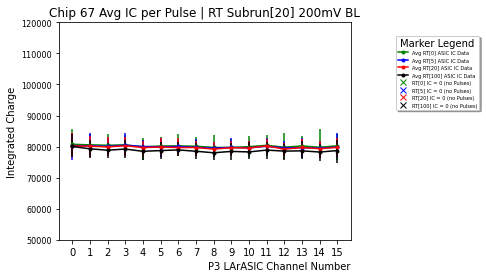

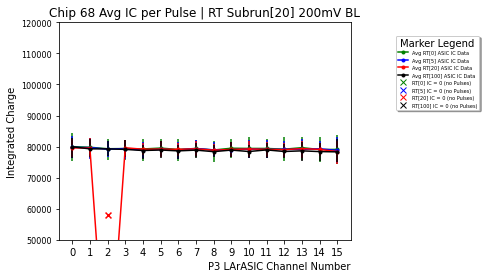

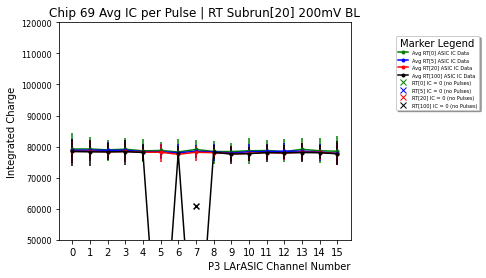

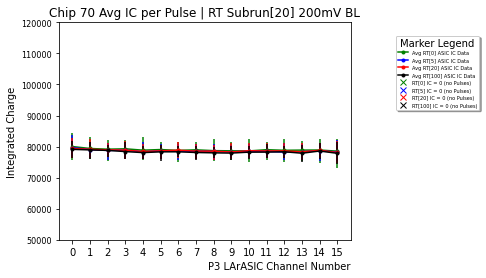

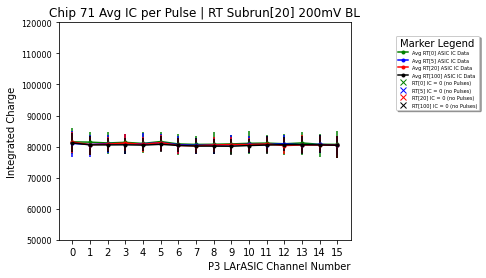

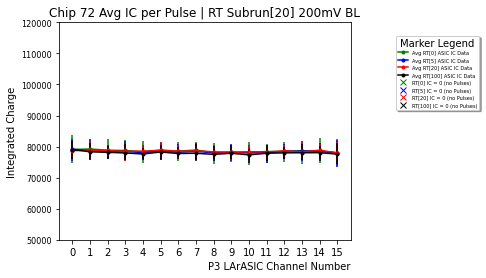

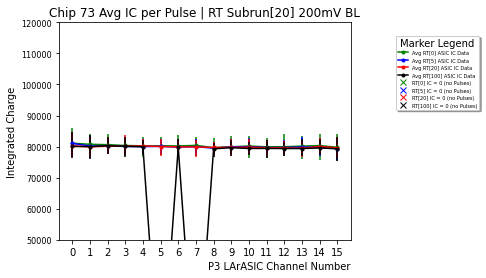

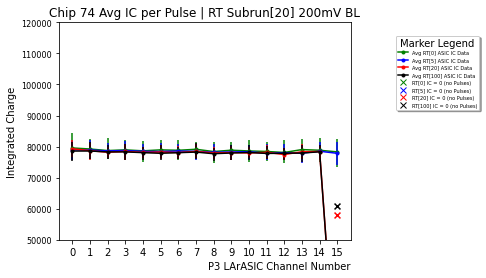

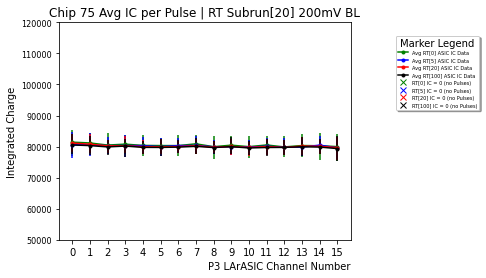

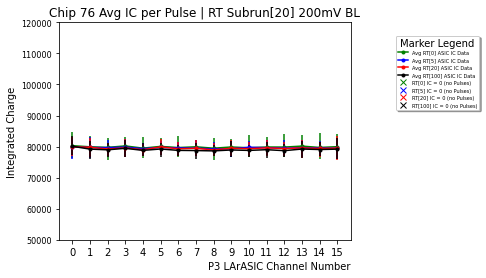

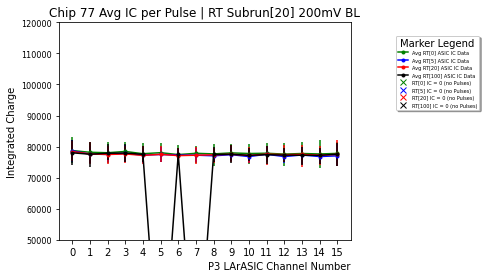

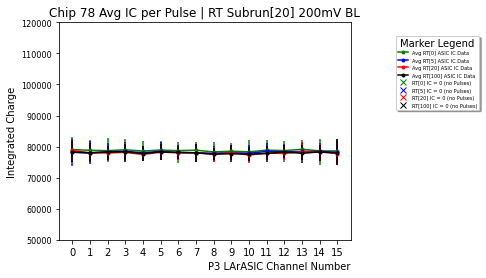

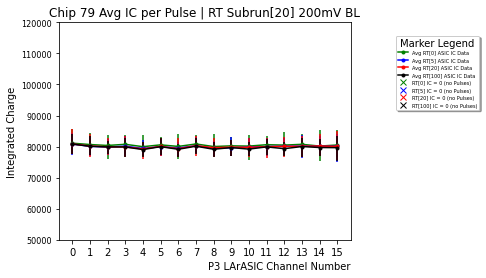

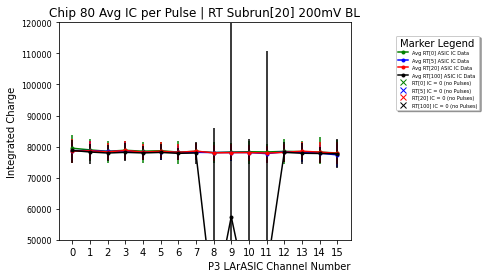

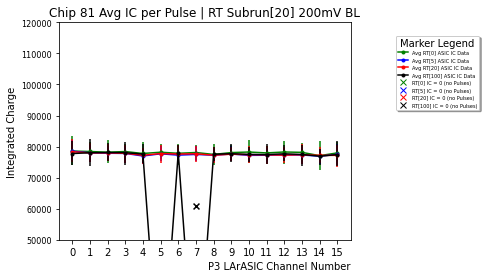

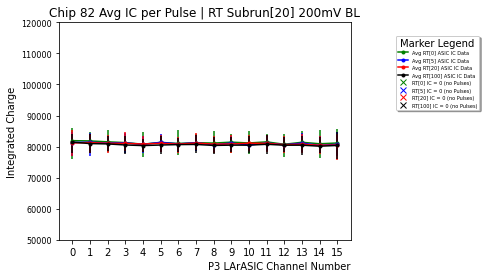

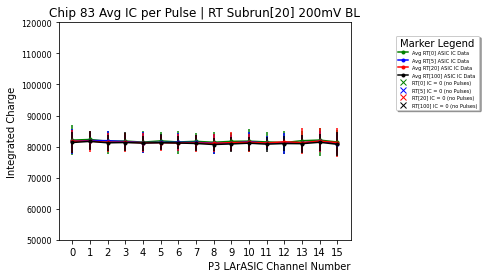

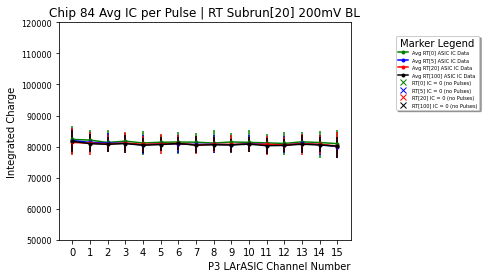

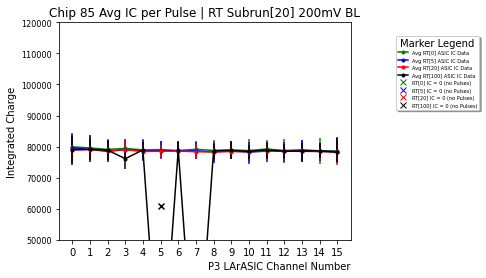

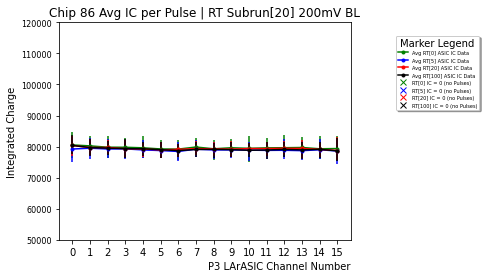

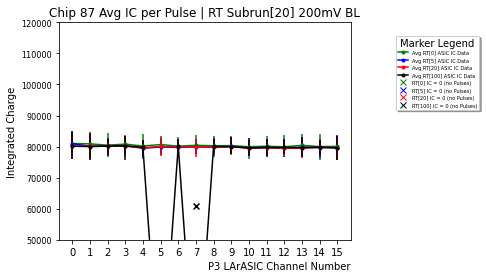

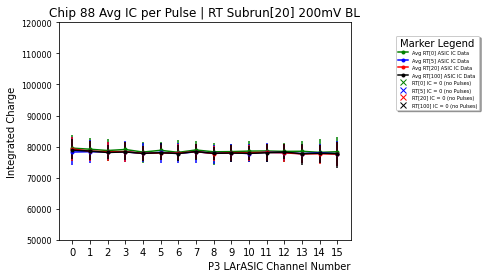

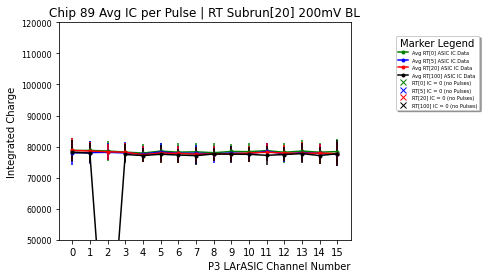

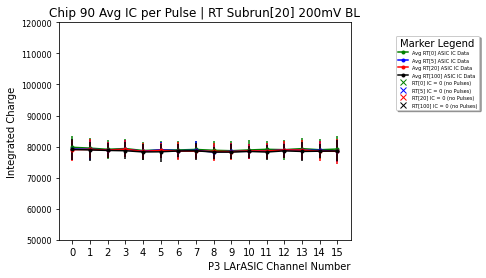

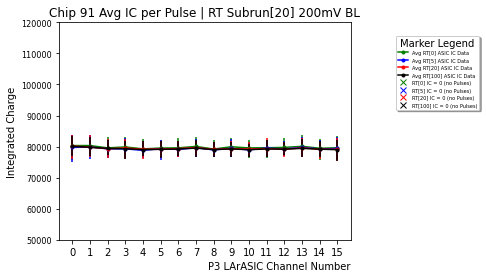

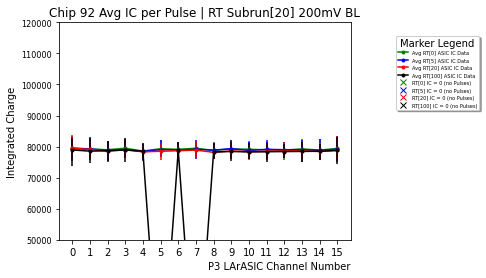

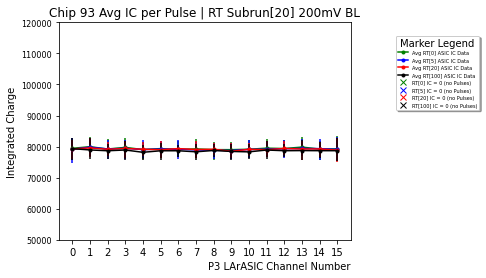

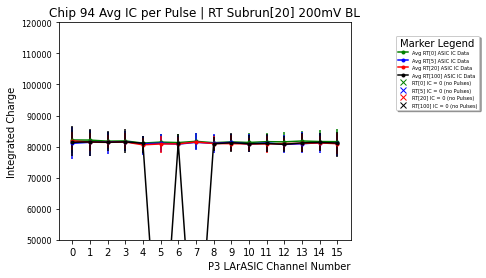

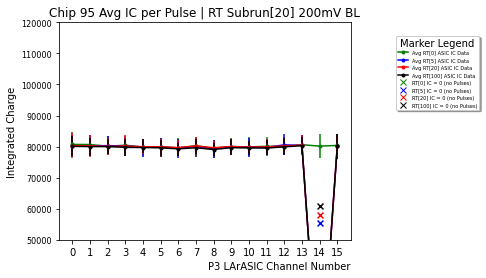

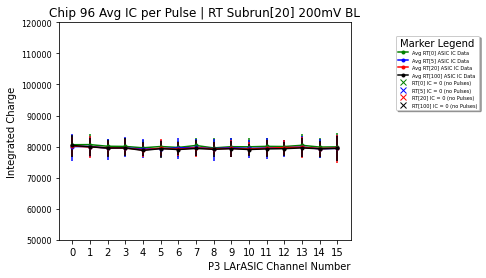

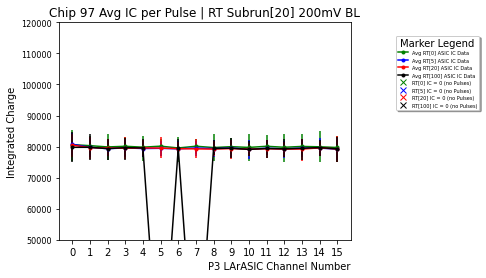

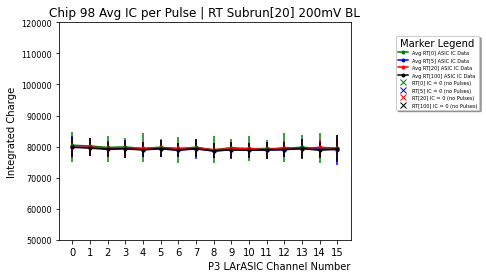

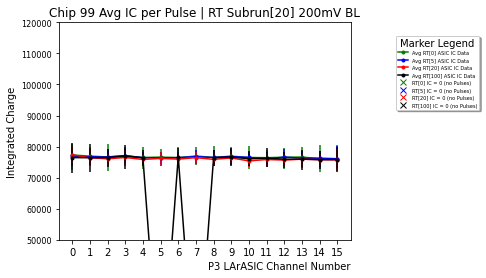

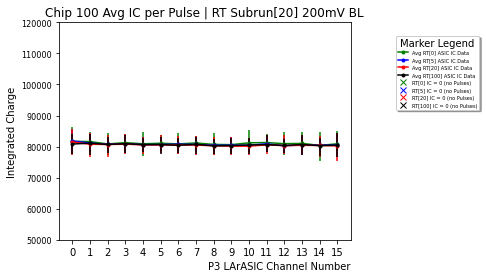

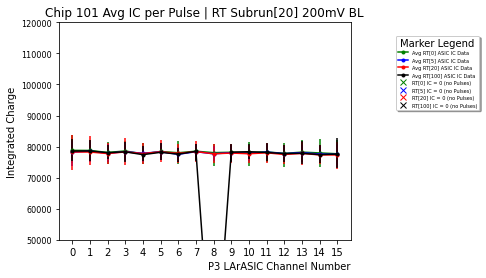

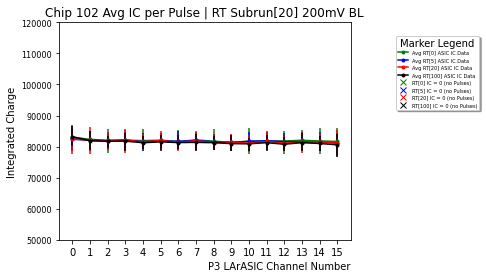

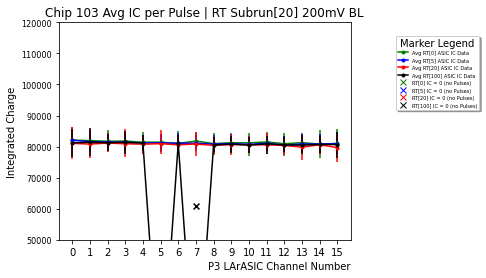

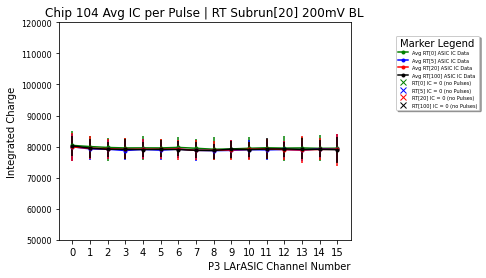

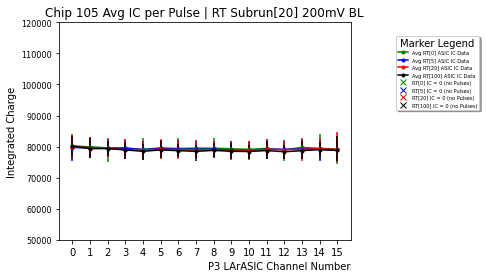

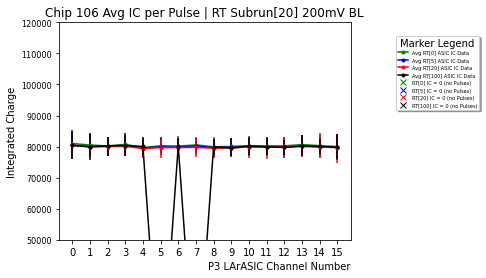

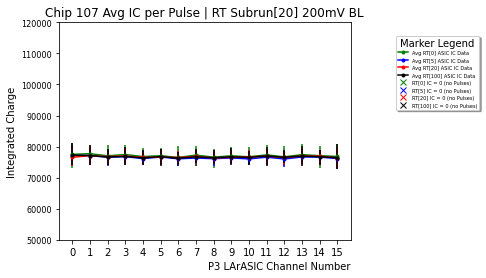

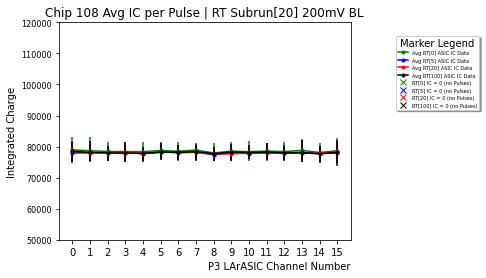

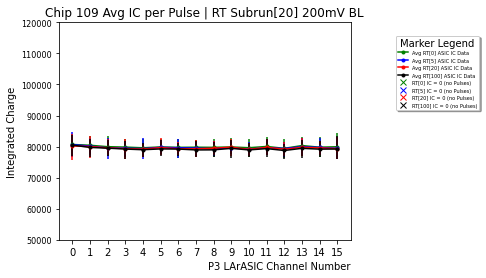

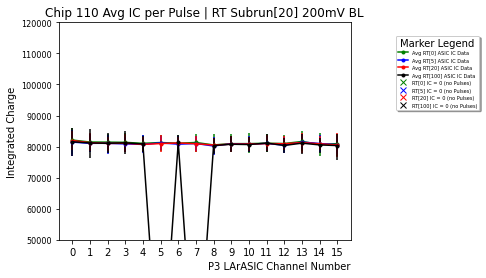

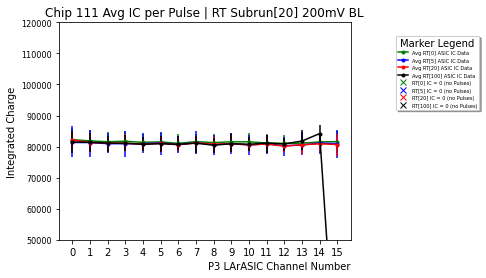

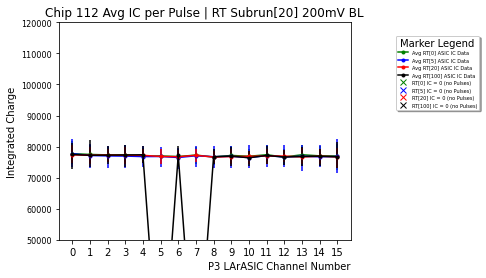

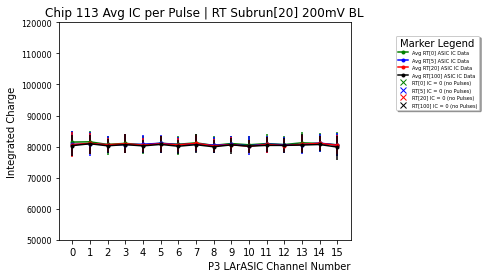

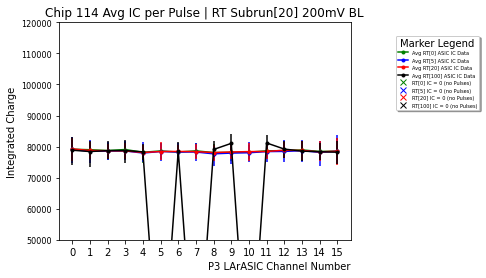

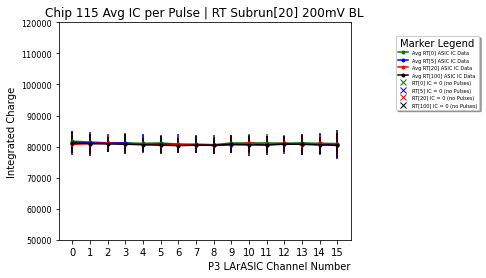

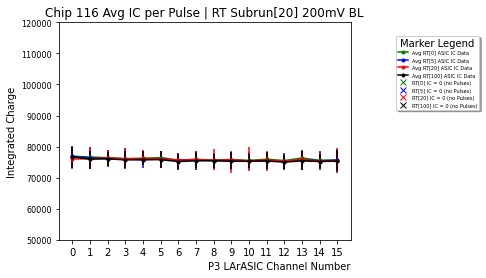

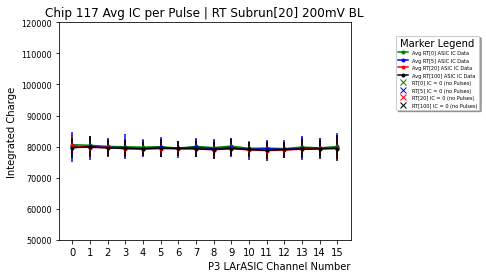

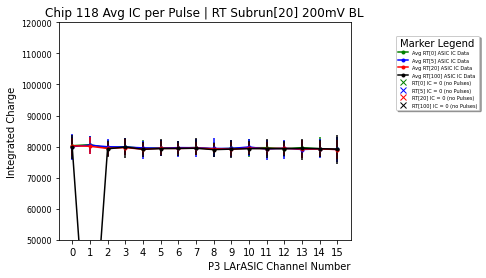

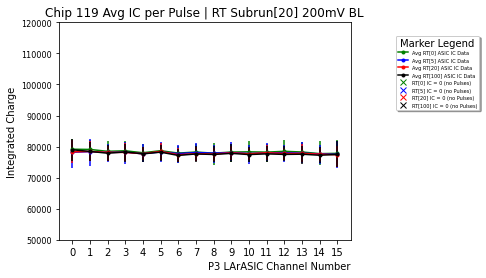


done


In [17]:
'''Produce all chips'''

for i in range(len(chips)):
    chipIndex = int(i)
    Title = 'Chip ' + str(chipIndex+20) + ' Avg IC per Pulse | RT Subrun[20] 200mV BL'
    IntegratedCharge = IC[chipIndex]
    path = '../../Cryocycled Chip Catalog/' + str(i+20) + '/' + str(i+20) + ' RT IC.png'
    path_cache = '../../Cryocycled Chip Catalog Photo Cache/' + str(i+20) + ' RT IC.png'
    IntCharge(Title,IntegratedCharge,chipIndex,path,path_cache)
    
print('\ndone')

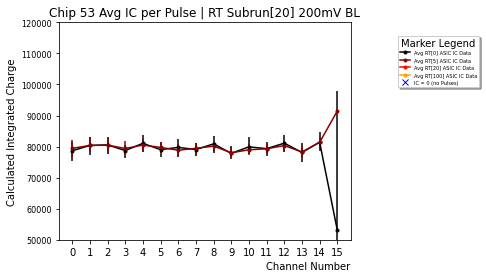

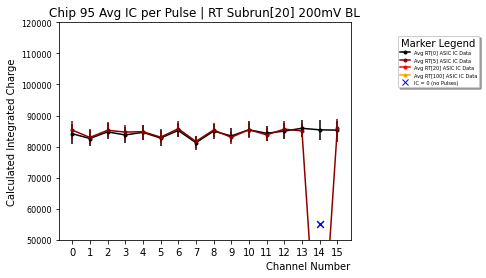


done


In [38]:
'''Produce only Problematic (outside of 5-sigma) Chips
############# RT[0] #############
Mean of IC Distribution =  83290.04
Sigma of IC Distribution =  2507.77
3-Sigma =  7523.3  [ 75766.74 : 90813.34 ]
5-Sigma =  12538.84  [ 70751.2 : 95828.88 ]
############# RT[5] #############
Mean of IC Distribution =  83068.57
Sigma of IC Distribution =  2368.82
3-Sigma =  7106.46  [ 75962.11 : 90175.03 ]
5-Sigma =  11844.1  [ 71224.47 : 94912.67 ]
'''

mu_0 = 83290.04; sig_0 = 2507.77  # RT[0] Distributions for Pulse FWHM
mu_5 = 83068.57; sig_5 = 2368.82   # RT[5] Distribution

plus5_RT0 = (mu_0 + 5*sig_0); minus5_RT0 = (mu_0 - 5*sig_0)
plus5_RT5 = (mu_5 + 5*sig_5); minus5_RT5 = (mu_5 - 5*sig_5)

sigma = [[plus5_RT0, minus5_RT0],[plus5_RT5, minus5_RT5]]

IN = [i for i in range(len(chips))]

# State that if any of the channels for an ASIC have pulse widths outside of 5-sigma for any of their 
# cryocycles to append an array (RTcounter) - if that array is non-zero for any element (an ASIC)
# plot and save that ASIC to a directory

RTcounter = [0 for i in range(len(chips))]
for i in IN:
    for c in range(len(Cryocycles)):
        for j in range(0,16):
            if any(e > sigma[c][0] for e in Total[i][c][j]) or any(e < sigma[c][1] for e in Total[i][c][j]) or \
            len(Total[i][c][j]) == 0.:
                RTcounter[i] = RTcounter[i] + 1.

# plot any ASICs with non-zero values (corresponding to any pulses in any channels having FWHM values
# outside of 5-sigma from the mean) in the RTcounter array to a 'Problematic Chips' directory

for i in IN:
    if RTcounter[i] != 0.:
        chipIndex = int(i)
        Title = 'Chip ' + str(chipIndex+20) + ' Avg IC per Pulse | RT Subrun[20] 200mV BL'
        IntegratedCharge = IC[chipIndex]
        path = '../../Plots/Cryocycle Comparison/IC and PW/Problematic Chips RT/RT CC IC '+str(i+20)+'.png'
        path_cache = '../../../../../test.png'
        IntCharge(Title,IntegratedCharge,chipIndex,path,path_cache)


print('\ndone')

### Statistics on which ASICs have values outside the nominal distribution

In [32]:
'''
############# RT[0] #############
Mean of IC Distribution =  80076.13
Sigma of IC Distribution =  2222.99

Mean of PW Distribution =  11.95
Sigma of PW Distribution =  0.18

############# RT[5] #############
Mean of IC Distribution =  79755.04
Sigma of IC Distribution =  2041.59

Mean of PW Distribution =  11.93
Sigma of PW Distribution =  0.19

############# RT[20] #############
Mean of IC Distribution =  79688.16
Sigma of IC Distribution =  2128.6

Mean of PW Distribution =  11.93
Sigma of PW Distribution =  0.2
'''

mu0_IC = 80076.13; std0_IC = 2222.99
mu0_PW = 11.95; std0_PW = 0.18
mu5_IC = 79755.04; std5_IC = 2041.59
mu5_PW = 11.93; std5_PW = 0.19
mu20_IC = 79688.16; std20_IC = 2128.6
mu20_PW = 11.93; std20_PW = 0.2

##### RT[0] #####
print('RT[0]\n')
# IC
print('IC')
count = []
for j in range(len(IC)):
    for k in range(len(IC[j][0])):
        if any(e > (mu0_IC + 5*std0_IC) or e < (mu0_IC - 5*std0_IC) for e in IC[j][0][k]):
            count.append('chip ' + str(j+20))
count = list(set(count))   # remove redundancies
print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal IC distribution')
print(str(round(100*(len(count)/len(chips)),2))+ ' % of chips with at least one abnormal channel')
print(count,'\n')

# PW
print('PW')
count = []
for j in range(len(Avg_W)):
    for k in range(len(Avg_W[j][0])):
        if any(e > (mu0_PW + 5*std0_PW) or e < (mu0_PW - 5*std0_PW) for e in Avg_W[j][0][k]):
            count.append('chip ' + str(j+20))
count = list(set(count))   # remove redundancies
print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal PW distribution')
print(str(round(100*(len(count)/len(chips)),2))+ ' % of chips with at least one abnormal channel')
print(count,'\n')

##### RT[5] #####
print('\nRT[5]\n')
# IC
print('IC')
count = []
for j in range(len(IC)):
    for k in range(len(IC[j][1])):
        if any(e > (mu5_IC + 5*std5_IC) or e < (mu5_IC - 5*std5_IC) for e in IC[j][1][k]):
            count.append('chip ' + str(j+20))
count = list(set(count))   # remove redundancies
print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal IC distribution')
print(str(round(100*(len(count)/len(chips)),2))+ ' % of chips with at least one abnormal channel')
print(count,'\n')

# PW
print('PW')
count = []
for j in range(len(Avg_W)):
    for k in range(len(Avg_W[j][1])):
        if any(e > (mu5_PW + 5*std5_PW) or e < (mu5_PW - 5*std5_PW) for e in Avg_W[j][1][k]):
            count.append('chip ' + str(j+20))
count = list(set(count))   # remove redundancies
print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal PW distribution')
print(str(round(100*(len(count)/len(chips)),2))+ ' % of chips with at least one abnormal channel')
print(count,'\n')

##### RT[20] #####
print('\nRT[20]\n')
# IC
print('IC')
count = []
for j in range(len(IC)):
    for k in range(len(IC[j][2])):
        if any(e > (mu20_IC + 5*std20_IC) or e < (mu20_IC - 5*std20_IC) for e in IC[j][2][k]):
            count.append('chip ' + str(j+20))
count = list(set(count))   # remove redundancies
print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal IC distribution')
print(str(round(100*(len(count)/len(chips)),2))+ ' % of chips with at least one abnormal channel')
print(count,'\n')

# PW
print('PW')
count = []
for j in range(len(Avg_W)):
    for k in range(len(Avg_W[j][2])):
        if any(e > (mu20_PW + 5*std20_PW) or e < (mu20_PW - 5*std20_PW) for e in Avg_W[j][2][k]):
            count.append('chip ' + str(j+20))
count = list(set(count))   # remove redundancies
print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal PW distribution')
print(str(round(100*(len(count)/len(chips)),2))+ ' % of chips with at least one abnormal channel')
print(count)

RT[0]

IC

1 Chips with at least one channel outside of 5σ from mean of Nominal IC distribution
1.0 % of chips with at least one abnormal channel
['chip 53'] 

PW

1 Chips with at least one channel outside of 5σ from mean of Nominal PW distribution
1.0 % of chips with at least one abnormal channel
['chip 53'] 


RT[5]

IC

2 Chips with at least one channel outside of 5σ from mean of Nominal IC distribution
2.0 % of chips with at least one abnormal channel
['chip 95', 'chip 41'] 

PW

2 Chips with at least one channel outside of 5σ from mean of Nominal PW distribution
2.0 % of chips with at least one abnormal channel
['chip 95', 'chip 41'] 


RT[20]

IC

5 Chips with at least one channel outside of 5σ from mean of Nominal IC distribution
5.0 % of chips with at least one abnormal channel
['chip 68', 'chip 95', 'chip 52', 'chip 74', 'chip 53'] 

PW

5 Chips with at least one channel outside of 5σ from mean of Nominal PW distribution
5.0 % of chips with at least one abnormal channel
['chip

### Plot an individual Waveform (SR[20]) for a given ASIC channel

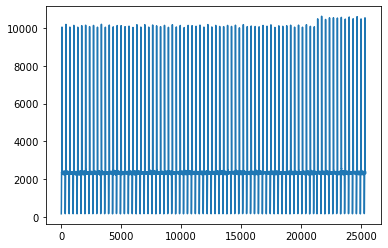

In [50]:
plt.plot(xpoints_Ch[6][1][4],ypoints_Ch[6][1][4])
#plt.xlim([5000,6000])

[]
